In [ ]:
!gdown 1RHT7e2GV91p5sz9d4HpB9fpKFmAcbH1ya

Downloading...
From (original): https://drive.google.com/uc?id=1RHT7e2GV91p5sz9d4HpB9fpKFmAcbH1y
From (redirected): https://drive.google.com/uc?id=1RHT7e2GV91p5sz9d4HpB9fpKFmAcbH1y&confirm=t&uuid=127f655b-c500-4ace-89da-405d30090a9b
To: /content/Datasets.rar
100% 230M/230M [00:01<00:00, 160MB/s]


In [ ]:
!unrar x /content/Datasets.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Datasets.rar

Creating    Datasets                                                  OK
Creating    Datasets/BUS                                              OK
Extracting  Datasets/BUS/.DS_Store                                         0%  OK 
Extracting  Datasets/BUS/DatasetB.xlsx                                     0%  OK 
Creating    Datasets/BUS/GT                                           OK
Extracting  Datasets/BUS/GT/000001.png                                     0%  OK 
Extracting  Datasets/BUS/GT/000002.png                                     0%  OK 
Extracting  Datasets/BUS/GT/000003.png                                     0%  OK 
Extracting  Datasets/BUS/GT/000004.png                                     0%  OK 
Extracting  Datasets/BUS/GT/000005.png                                     0%  OK 
Extracting  Datasets/B

In [ ]:
from functools import reduce

import pdb
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.models import resnext50_32x4d, resnext101_32x8d

In [ ]:
from functools import reduce

import torch
import torch.nn as nn
from torchvision.models import resnext50_32x4d, resnext101_32x8d

class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input

class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))

class LambdaMap(LambdaBase):
    def forward(self, input):
        return list(map(self.lambda_func, self.forward_prepare(input)))

class LambdaReduce(LambdaBase):
    def forward(self, input):
        return reduce(self.lambda_func, self.forward_prepare(input))

def resnext50():
    model  = resnext50_32x4d()
    model.conv1 = nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), 1, 1, bias = False)
    model.avgpool = nn.AvgPool2d((7,7), (1, 1))
    model.fc = nn.Sequential(
        Lambda(lambda  x: x.view(x.size(0), -1)),
        Lambda(lambda  x: x.view(1, -1) if 1 == len(x.size()) else x),
        nn.Linear(2048, 1000)
    )
    return model

def resnext101():
    model  = resnext101_32x8d()
    model.conv1 = nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), 1, 1, bias = False)
    model.avgpool = nn.AvgPool2d((7,7), (1, 1))
    model.fc = nn.Sequential(
        Lambda(lambda  x: x.view(x.size(0), -1)),
        Lambda(lambda  x: x.view(1, -1) if 1 == len(x.size()) else x),
        nn.Linear(2048, 1000)
    )
    return model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
dummy_in = torch.randint(0, 255, (1, 1, 256, 256))
out = model(dummy_in.float())
print(out.shape)

modell = list(model.features)
print(len(modell))
init_layers = nn.Sequential(*modell[0:4])
d1 = model.features.denseblock1#modell[4]
t1 = model.features.transition1
d2 = model.features.denseblock2
t2 = model.features.transition2
d3 = model.features.denseblock3
t3 = model.features.transition3
d4 = model.features.denseblock4

inter1 = init_layers(dummy_in.float())
inter2 = d1(inter1)
inter2t = t1(inter2)
inter3 = d2(inter2t)
inter3t = t2(inter3)
inter4 = d3(inter3t)
inter4t = t3(inter4)
inter5 = d4(inter4t)
print(inter2.shape)
print(inter3.shape)
print(inter4.shape)
print(inter5.shape)



torch.Size([1, 1000])
12
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 8, 8])


In [ ]:
class ResNeXt101(nn.Module):
    def __init__(self):
        super(ResNeXt101, self).__init__()
        net = resnext101()

        net = list(net.children())
        self.layer0 = nn.Sequential(*net[:3])
        self.layer1 = nn.Sequential(*net[3: 5])
        self.layer2 = net[5]
        self.layer3 = net[6]
        self.layer4 = net[7]

    def forward(self, x):
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        return layer4

In [ ]:
__all__ = ['PAM_Module', 'CAM_Module', 'semanticModule']

class _EncoderBlock(nn.Module):
    """
    Encoder block for Semantic Attention Module
    """
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    """
    Decoder Block for Semantic Attention Module
    """
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class semanticModule(nn.Module):
    """
    Semantic attention module
    """
    def __init__(self, in_dim):
        super(semanticModule, self).__init__()
        self.chanel_in = in_dim

        self.enc1 = _EncoderBlock(in_dim, in_dim*2)
        self.enc2 = _EncoderBlock(in_dim*2, in_dim*4)
        self.dec2 = _DecoderBlock(in_dim * 4, in_dim * 2, in_dim * 2)
        self.dec1 = _DecoderBlock(in_dim * 2, in_dim, in_dim )

    def forward(self,x):

        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)

        dec2 = self.dec2( enc2)
        dec1 = self.dec1( F.upsample(dec2, enc1.size()[2:], mode='bilinear'))

        return enc2.view(-1), dec1

class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        """
        Parameters:
        ----------
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)

        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out


class CAM_Module(nn.Module):
    """ Channel attention module"""
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
    def forward(self,x):
        """
        Parameters:
        ----------
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)

        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out

class PAM_CAM_Layer(nn.Module):
    """
    Helper Function for PAM and CAM attention

    Parameters:
    ----------
    input:
        in_ch : input channels
        use_pam : Boolean value whether to use PAM_Module or CAM_Module
    output:
        returns the attention map
    """
    def __init__(self, in_ch, use_pam = True):
        super(PAM_CAM_Layer, self).__init__()

        self.attn = nn.Sequential(
            nn.Conv2d(in_ch * 2, in_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_ch),
            nn.PReLU(),
            PAM_Module(in_ch) if use_pam else CAM_Module(in_ch),
			nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_ch),
            nn.PReLU()
        )

    def forward(self, x):
        return self.attn(x)

class MultiConv(nn.Module):
    """
    Helper function for Multiple Convolutions for refining.

    Parameters:
    ----------
    inputs:
        in_ch : input channels
        out_ch : output channels
        attn : Boolean value whether to use Softmax or PReLU
    outputs:
        returns the refined convolution tensor
    """
    def __init__(self, in_ch, out_ch, attn = True):
        super(MultiConv, self).__init__()

        self.fuse_attn = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.Softmax2d() if attn else nn.PReLU()
        )

    def forward(self, x):
        return self.fuse_attn(x)

In [ ]:
class NormConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(NormConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x1 = self.conv(x)
        x1 = self.bn(x1)
        return F.relu(x1, inplace=True)

class NormUpConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(NormUpConv2d, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.upconv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Bupsamp(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, **kwargs):
        super(Bupsamp, self).__init__()
        self.upconv = NormUpConv2d(in_channels, out_channels, kernel_size=3, stride = stride, bias=False, **kwargs)
        self.conv1 = NormConv2d(out_channels, out_channels, kernel_size=2, padding=1)
        self.conv2 = NormConv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = NormConv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.upconv(x)
        x2 = self.conv1(x1)
        x2 = self.conv2(x2)
        x2 = self.conv3(x2)
        #out = x1 + x2
        return x2

class DAF_stack(nn.Module):
    def __init__(self):
        super(DAF_stack, self).__init__()
        self.resnext = ResNeXt101()

        self.dense = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        self.dense.features.conv0 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        modell = list(self.dense.features)
        self.init_layers = nn.Sequential(*modell[0:4])
        self.d1 = self.dense.features.denseblock1
        self.t1 = self.dense.features.transition1
        self.d2 = self.dense.features.denseblock2
        self.t2 = self.dense.features.transition2
        self.d3 = self.dense.features.denseblock3
        self.t3 = self.dense.features.transition3
        self.d4 = self.dense.features.denseblock4

        self.upch = nn.Conv2d(1024, 2048, kernel_size = 1)


        self.up_sample4 = nn.Sequential(
            Bupsamp(2048, 1024, stride = 2, padding=1),
            Bupsamp(1024, 512, stride = 2, padding=1),
            Bupsamp(512, 256, stride = 2, padding=1)
        )
        self.up_sample3 = nn.Sequential(
            Bupsamp(1024, 512, stride = 2, padding=1),
            Bupsamp(512, 256, stride = 2, padding=1)
        )
        self.up_sample2 = nn.Sequential(
            Bupsamp(512, 256, stride = 2, padding=1)
        )

        self.down4 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1), nn.BatchNorm2d(64), nn.PReLU()
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1), nn.BatchNorm2d(64), nn.PReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1), nn.BatchNorm2d(64), nn.PReLU()
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1), nn.BatchNorm2d(64), nn.PReLU()
        )

        inter_channels = 64
        out_channels=64

        self.dout = nn.Dropout2d(0.1)

        self.conv6_1 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv6_2 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv6_3 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv6_4 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))

        self.conv7_1 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv7_2 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv7_3 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))
        self.conv7_4 = nn.Sequential(nn.Dropout2d(0.3, False), nn.Conv2d(64, out_channels, 1))

        self.conv8_1=nn.Conv2d(64,64,1)
        self.conv8_2=nn.Conv2d(64,64,1)
        self.conv8_3=nn.Conv2d(64,64,1)
        self.conv8_4=nn.Conv2d(64,64,1)
        self.conv8_11=nn.Conv2d(64,64,1)
        self.conv8_12=nn.Conv2d(64,64,1)
        self.conv8_13=nn.Conv2d(64,64,1)
        self.conv8_14=nn.Conv2d(64,64,1)

        self.softmax_1 = nn.Softmax(dim=-1)

        self.pam_attention_1_1= PAM_CAM_Layer(64, True)
        self.cam_attention_1_1= PAM_CAM_Layer(64, False)
        self.semanticModule_1_1 = semanticModule(128)

        self.conv_sem_1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_1_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_1_3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_1_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        #Dual Attention mechanism
        self.pam_attention_1_2 = PAM_CAM_Layer(64)
        self.cam_attention_1_2 = PAM_CAM_Layer(64, False)
        self.pam_attention_1_3 = PAM_CAM_Layer(64)
        self.cam_attention_1_3 = PAM_CAM_Layer(64, False)
        self.pam_attention_1_4 = PAM_CAM_Layer(64)
        self.cam_attention_1_4 = PAM_CAM_Layer(64, False)

        self.pam_attention_2_1 = PAM_CAM_Layer(64)
        self.cam_attention_2_1 = PAM_CAM_Layer(64, False)
        self.semanticModule_2_1 = semanticModule(128)

        self.conv_sem_2_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_2_3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_sem_2_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.pam_attention_2_2 = PAM_CAM_Layer(64)
        self.cam_attention_2_2 = PAM_CAM_Layer(64, False)
        self.pam_attention_2_3 = PAM_CAM_Layer(64)
        self.cam_attention_2_3 = PAM_CAM_Layer(64, False)
        self.pam_attention_2_4 = PAM_CAM_Layer(64)
        self.cam_attention_2_4 = PAM_CAM_Layer(64, False)

        self.fuse1 = MultiConv(256, 64, False)

        self.attention4 = MultiConv(128, 64)
        self.attention3 = MultiConv(128, 64)
        self.attention2 = MultiConv(128, 64)
        self.attention1 = MultiConv(128, 64)

        self.refine4 = MultiConv(128, 64, False)
        self.refine3 = MultiConv(128, 64, False)
        self.refine2 = MultiConv(128, 64, False)
        self.refine1 = MultiConv(128, 64, False)

        self.predict4 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict3 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict2 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict1 = nn.Conv2d(64, 2, kernel_size=1)

        self.predict4_2 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict3_2 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict2_2 = nn.Conv2d(64, 2, kernel_size=1)
        self.predict1_2 = nn.Conv2d(64, 2, kernel_size=1)

        self.refbuffer1 = nn.Linear(64, 64)
        self.refbuffer2 = nn.Linear(64, 64)
        self.refbuffer3 = nn.Linear(64, 64)

    def forward(self, x):
        layer0 = self.init_layers(x)
        layer1 = self.d1(layer0)
        layer2 = self.t1(layer1)
        layer2 = self.d2(layer2)
        layer3 = self.t2(layer2)
        layer3 = self.d3(layer3)
        layer4 = self.t3(layer3)
        layer4 = self.d4(layer4)
        layer4 = self.upch(layer4)

        #layer0 = self.resnext.layer0(x)
        #layer1 = self.resnext.layer1(layer0)
        #layer2 = self.resnext.layer2(layer1)
        #layer3 = self.resnext.layer3(layer2)
        #layer4 = self.resnext.layer4(layer3)
        #print('layer 4, 3, 2, 1: ', layer4.shape, layer3.shape, layer2.shape, layer1.shape)
        down4 = self.up_sample4(layer4)
        down4 = self.down4(down4)

        down3 = self.up_sample3(layer3)
        down3 = self.down3(down3)

        down2 = self.up_sample2(layer2)
        down2 = self.down2(down2)

        down1 = self.down1(layer1)
        #down4 = F.upsample(self.down4(layer4), size=layer1.size()[2:], mode='bilinear')
        #down3 = F.upsample(self.down3(layer3), size=layer1.size()[2:], mode='bilinear')
        #down2 = F.upsample(self.down2(layer2), size=layer1.size()[2:], mode='bilinear')
        #down1 = self.down1(layer1)
        #print('layer 4, 3, 2, 1: ', down4.shape, down3.shape, down2.shape, down1.shape)

        predict4 = self.predict4(down4)
        predict3 = self.predict3(down3)
        predict2 = self.predict2(down2)
        predict1 = self.predict1(down1)

        fuse1 = self.fuse1(torch.cat((down4, down3, down2, down1), 1))
        #fuse1 = self.dout(fuse1)

        semVector_1_1,semanticModule_1_1 = self.semanticModule_1_1(torch.cat((down4, fuse1),1))


        attn_pam4 = self.pam_attention_1_4(torch.cat((down4, fuse1), 1))
        attn_cam4 = self.cam_attention_1_4(torch.cat((down4, fuse1), 1))

        attention1_4=self.conv8_1((attn_cam4+attn_pam4)*self.conv_sem_1_1(semanticModule_1_1))

        semVector_1_2, semanticModule_1_2 = self.semanticModule_1_1(torch.cat((down3, fuse1), 1))
        attn_pam3 = self.pam_attention_1_3(torch.cat((down3, fuse1), 1))
        attn_cam3 = self.cam_attention_1_3(torch.cat((down3, fuse1), 1))
        attention1_3=self.conv8_2((attn_cam3+attn_pam3)*self.conv_sem_1_2(semanticModule_1_2))

        semVector_1_3, semanticModule_1_3 = self.semanticModule_1_1(torch.cat((down2, fuse1), 1))
        attn_pam2 = self.pam_attention_1_2(torch.cat((down2, fuse1), 1))
        attn_cam2 = self.cam_attention_1_2(torch.cat((down2, fuse1), 1))
        attention1_2=self.conv8_3((attn_cam2+attn_pam2)*self.conv_sem_1_3(semanticModule_1_3))

        semVector_1_4, semanticModule_1_4 = self.semanticModule_1_1(torch.cat((down1, fuse1), 1))
        attn_pam1 = self.pam_attention_1_1(torch.cat((down1, fuse1), 1))
        attn_cam1 = self.cam_attention_1_1(torch.cat((down1, fuse1), 1))
        attention1_1 = self.conv8_4((attn_cam1+attn_pam1) * self.conv_sem_1_4(semanticModule_1_4))

        ##new design with stacked attention

        semVector_2_1, semanticModule_2_1 = self.semanticModule_2_1(torch.cat((down4, attention1_4 * fuse1), 1))

        refine4_1 = self.pam_attention_2_4(torch.cat((down4,attention1_4*fuse1),1))
        refine4_2 = self.cam_attention_2_4(torch.cat((down4,attention1_4*fuse1),1))
        att4 = refine4_1+refine4_2
        refine4 = self.conv8_11((refine4_1+refine4_2) * self.conv_sem_2_1(semanticModule_2_1))

        semVector_2_2, semanticModule_2_2 = self.semanticModule_2_1(torch.cat((down3, attention1_3 * fuse1), 1))
        refine3_1 = self.pam_attention_2_3(torch.cat((down3,attention1_3*fuse1),1))
        refine3_2 = self.cam_attention_2_3(torch.cat((down3,attention1_3*fuse1),1))
        att3 = refine3_1+refine3_2
        refine3 = self.conv8_12((refine3_1+refine3_2) * self.conv_sem_2_2(semanticModule_2_2))

        semVector_2_3, semanticModule_2_3 = self.semanticModule_2_1(torch.cat((down2, attention1_2 * fuse1), 1))
        refine2_1 = self.pam_attention_2_2(torch.cat((down2,attention1_2*fuse1),1))
        refine2_2 = self.cam_attention_2_2(torch.cat((down2,attention1_2*fuse1),1))
        att2 = refine2_1+refine2_2
        refine2 = self.conv8_13((refine2_1+refine2_2) * self.conv_sem_2_3(semanticModule_2_3))

        semVector_2_4, semanticModule_2_4 = self.semanticModule_2_1(torch.cat((down1, attention1_1 * fuse1), 1))
        refine1_1 = self.pam_attention_2_1(torch.cat((down1,attention1_1 * fuse1),1))
        refine1_2 = self.cam_attention_2_1(torch.cat((down1,attention1_1 * fuse1),1))
        att1 = refine1_1+refine1_2
        refine1 = self.conv8_14((refine1_1+refine1_2) * self.conv_sem_2_4(semanticModule_2_4))
        #print('refine 4: ', refine4.shape)
        #print('refine 3: ', refine3.shape)
        #print('refine 2: ', refine2.shape)
        #print('refine 1: ', refine1.shape)

        predict4_2 = self.predict4_2(refine4)
        predict3_2 = self.predict3_2(refine3)
        predict2_2 = self.predict2_2(refine2)
        predict1_2 = self.predict1_2(refine1)

        predict1 = F.upsample(predict1, size=x.size()[2:], mode='bilinear')
        predict2 = F.upsample(predict2, size=x.size()[2:], mode='bilinear')
        predict3 = F.upsample(predict3, size=x.size()[2:], mode='bilinear')
        predict4 = F.upsample(predict4, size=x.size()[2:], mode='bilinear')

        predict1_2 = F.upsample(predict1_2, size=x.size()[2:], mode='bilinear')
        predict2_2 = F.upsample(predict2_2, size=x.size()[2:], mode='bilinear')
        predict3_2 = F.upsample(predict3_2, size=x.size()[2:], mode='bilinear')
        predict4_2 = F.upsample(predict4_2, size=x.size()[2:], mode='bilinear')

        #print('refine shapes 1-3: ', refine1.shape, refine2.shape, refine3.shape)
        refine1 = self.refbuffer1(refine1)
        refine2 = self.refbuffer2(refine2)
        refine3 = self.refbuffer3(refine3)

        if self.training:
            return semVector_1_1,\
                   semVector_2_1, \
                   semVector_1_2, \
                   semVector_2_2, \
                   semVector_1_3, \
                   semVector_2_3, \
                   semVector_1_4, \
                   semVector_2_4, \
                   torch.cat((down1, fuse1), 1),\
                   torch.cat((down2, fuse1), 1),\
                   torch.cat((down3, fuse1), 1),\
                   torch.cat((down4, fuse1), 1), \
                   torch.cat((down1, attention1_1 * fuse1), 1), \
                   torch.cat((down2, attention1_2 * fuse1), 1), \
                   torch.cat((down3, attention1_3 * fuse1), 1), \
                   torch.cat((down4, attention1_4 * fuse1), 1), \
                   semanticModule_1_4, \
                   semanticModule_1_3, \
                   semanticModule_1_2, \
                   semanticModule_1_1, \
                   semanticModule_2_4, \
                   semanticModule_2_3, \
                   semanticModule_2_2, \
                   semanticModule_2_1, \
                   predict1, \
                   predict2, \
                   predict3, \
                   predict4, \
                   predict1_2, \
                   predict2_2, \
                   predict3_2, \
                   predict4_2, refine4, refine3, refine2, refine1
        else:
            return predict1_2, predict2_2, predict3_2, predict4_2
            #return ((predict1_2 + predict2_2 + predict3_2 + predict4_2) / 4)


In [ ]:
import os
import numpy as np
import scipy.io as sio
import pdb
import time
from os.path import isfile, join

import nibabel as nib
from PIL import Image
# from medpy.metric.binary import dc,hd
import skimage.transform as skiTransf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

def load_nii(imageFileName, printFileNames):
    if printFileNames == True:
        print (" ... Loading file: {}".format(imageFileName))

    img_proxy = nib.load(imageFileName)
    imageData = img_proxy.get_data()

    return (imageData, img_proxy)

def evaluate3D(modelName):

    # Path where the ground truth (as nifti file) should be for comparisons
    path_GT = './DataSet_Challenge/GT_Nifti/Val_1'

    # Path where the predictions are saved
    path_Pred = 'Results/Images/' + modelName + '/Nifti'

    if not os.path.exists('Results/Images/' + modelName + '/Nifti/'):
        os.makedirs('Results/Images/' + modelName + '/Nifti/',exist_ok=True)
    GT_names = getImageImageList(path_GT)
    Pred_names = getImageImageList(path_Pred)

    GT_names.sort()
    Pred_names.sort()

    numClasses = 4
    DSC = np.zeros((len(Pred_names), numClasses))

    for s_i in range(len(Pred_names)):
        path_Subj_GT = path_GT +'/'+GT_names[s_i]
        path_Subj_pred = path_Pred +'/'+Pred_names[s_i]

        [imageDataGT, img_proxy] = load_nii(path_Subj_GT, printFileNames=False)
        [imageDataCNN, img_proxy] = load_nii(path_Subj_pred, printFileNames=False)

        for c_i in range(numClasses):
            label_GT = np.zeros(imageDataGT.shape, dtype=np.int8)
            label_CNN = np.zeros(imageDataCNN.shape, dtype=np.int8)
            idx_GT = np.where(imageDataGT == c_i+1)
            label_GT[idx_GT] = 1
            idx_CNN = np.where(imageDataCNN == c_i+1)
            label_CNN[idx_CNN] = 1

            DSC[s_i,c_i] = dc(label_GT,label_CNN)

    return DSC


def getImageImageList(imagesFolder):
    if os.path.exists(imagesFolder):
        imageNames = [f for f in os.listdir(imagesFolder) if isfile(join(imagesFolder, f))]

    imageNames.sort()

    return imageNames

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def reconstruct3D(modelName,epoch, isBest=False):

    path = 'Results/Images/' + modelName + '/' + str(epoch)
    subjNames = os.listdir(path)


    for s_i in range(len(subjNames)):
        path_Subj = path +'/'+subjNames[s_i]
        imgNames = getImageImageList(path_Subj)

        numImages = len(imgNames)

        xSize = 256
        ySize = 256
        vol_numpy = np.zeros((xSize, ySize, numImages))

        for t_i in range(numImages-1):

            imagePIL = Image.open(path_Subj + '/'+str(t_i+1)+'.png').convert('LA')
            imageNP = np.array(imagePIL)
            vol_numpy[:, :, t_i] = imageNP[:,:,0]/63 # To have labels in the range [0,1,2]

            xform = np.eye(4) * 2
            imgNifti = nib.nifti1.Nifti1Image(vol_numpy, xform)
            if not os.path.exists('Results/Images/' + modelName + '/Nifti/'):
                os.makedirs('Results/Images/' + modelName + '/Nifti/',exist_ok=True)
            niftiName = 'Results/Images/' + modelName + '/Nifti/' + subjNames[s_i]
            nib.save(imgNifti, niftiName)

            if (isBest):
                if not os.path.exists('Results/Images/' + modelName + '/Nifti_Best/'):
                    os.makedirs('Results/Images/' + modelName + '/Nifti_Best/', exist_ok=True)
            niftiName = 'Results/Images/' + modelName + '/Nifti_Best/' + subjNames[s_i]
            nib.save(imgNifti, niftiName)


class computeDiceOneHot(nn.Module):
    def __init__(self):
        super(computeDiceOneHot, self).__init__()

    def dice(self, input, target):
        inter = (input * target).float().sum()
        sum = input.sum() + target.sum()
        if (sum == 0).all():
            return (2 * inter + 1e-8) / (sum + 1e-8)

        return 2 * (input * target).float().sum() / (input.sum() + target.sum())

    def inter(self, input, target):
        return (input * target).float().sum()

    def sum(self, input, target):
        return input.sum() + target.sum()

    def forward(self, pred, GT):
        # GT is 4x320x320 of 0 and 1
        # pred is converted to 0 and 1
        batchsize = GT.size(0)
        DiceN = to_var(torch.zeros(batchsize, 2))
        DiceB = to_var(torch.zeros(batchsize, 2))
        DiceW = to_var(torch.zeros(batchsize, 2))
        DiceT = to_var(torch.zeros(batchsize, 2))
        DiceZ = to_var(torch.zeros(batchsize, 2))

        for i in range(batchsize):
            DiceN[i, 0] = self.inter(pred[i, 0], GT[i, 0])
            DiceB[i, 0] = self.inter(pred[i, 1], GT[i, 1])
            DiceW[i, 0] = self.inter(pred[i, 2], GT[i, 2])
            DiceT[i, 0] = self.inter(pred[i, 3], GT[i, 3])
            DiceZ[i, 0] = self.inter(pred[i, 4], GT[i, 4])

            DiceN[i, 1] = self.sum(pred[i, 0], GT[i, 0])
            DiceB[i, 1] = self.sum(pred[i, 1], GT[i, 1])
            DiceW[i, 1] = self.sum(pred[i, 2], GT[i, 2])
            DiceT[i, 1] = self.sum(pred[i, 3], GT[i, 3])
            DiceZ[i, 1] = self.sum(pred[i, 4], GT[i, 4])

        return DiceN, DiceB , DiceW, DiceT, DiceZ


def DicesToDice(Dices):
    sums = Dices.sum(dim=0)
    return (2 * sums[0] + 1e-8) / (sums[1] + 1e-8)


def getSingleImage(pred):
    # input is a 4-channels image corresponding to the predictions of the net
    # output is a gray level image (1 channel) of the segmentation with "discrete" values
    num_classes = 5
    Val = to_var(torch.zeros(num_classes))

    # Chaos MRI
    Val[1] = 0.24705882
    Val[2] = 0.49411765
    Val[3] = 0.7411765
    Val[4] = 0.9882353

    x = predToSegmentation(pred)

    out = x * Val.view(1, 5, 1, 1)

    return out.sum(dim=1, keepdim=True)


def predToSegmentation(pred):
    Max = pred.max(dim=1, keepdim=True)[0]
    x = pred / Max
    return (x == 1).float()


def getOneHotSegmentation(batch):
    backgroundVal = 0

    # Chaos MRI (These values are to set label values as 0,1,2,3 and 4)
    label1 = 0.24705882
    label2 = 0.49411765
    label3 = 0.7411765
    label4 = 0.9882353

    oneHotLabels = torch.cat((batch == backgroundVal, batch == label1, batch == label2, batch == label3, batch == label4),
                             dim=1)

    return oneHotLabels.float()


def getTargetSegmentation(batch):
    # input is 1-channel of values between 0 and 1
    # values are as follows : 0, 0.3137255, 0.627451 and 0.94117647
    # output is 1 channel of discrete values : 0, 1, 2 and 3

    denom = 0.24705882 # for Chaos MRI  Dataset this value

    return (batch / denom).round().long().squeeze()


def saveImages_for3D(net, img_batch, batch_size, epoch, modelName, deepSupervision=False, isBest= False):
    # print(" Saving images.....")
    path = 'Results/Images/' + modelName + '/' + str(epoch)
    if not os.path.exists(path):
        os.makedirs(path)


    total = len(img_batch)
    net.eval()
    softMax = nn.Softmax()
    for i, data in enumerate(img_batch):
        image, labels, img_names = data

        MRI = to_var(image)
        Segmentation = to_var(labels)

        segmentation_prediction = net(MRI)

        pred_y = softMax(segmentation_prediction)

        segmentation = getSingleImage(pred_y)

        out = torch.cat((MRI, segmentation, Segmentation))

        str_1 = img_names[0].split('/Img/')
        str_subj = str_1[1].split('slice')

        path_Subj = path + '/' + str_subj[0]
        if not os.path.exists(path_Subj):
            os.makedirs(path_Subj)

        str_subj = str_subj[1].split('_')
        torchvision.utils.save_image(segmentation.data, os.path.join(path_Subj, str_subj[1]))
    printProgressBar(total, total, done="Images saved !")


def inference(net, img_batch):
    total = len(img_batch)

    Dice1 = torch.zeros(total, 2)
    Dice2 = torch.zeros(total, 2)
    Dice3 = torch.zeros(total, 2)
    Dice4 = torch.zeros(total, 2)

    net.eval()
    img_names_ALL = []

    dice = computeDiceOneHot().cuda()
    softMax = nn.Softmax().cuda()
    for i, data in enumerate(img_batch):

        printProgressBar(i, total, prefix="[Inference] Getting segmentations...", length=30)
        image, labels, img_names = data
        img_names_ALL.append(img_names[0].split('/')[-1].split('.')[0])

        MRI = to_var(image)
        Segmentation = to_var(labels)

        segmentation_prediction = net(MRI)

        pred_y = softMax(segmentation_prediction)
        Segmentation_planes = getOneHotSegmentation(Segmentation)

        segmentation_prediction_ones = predToSegmentation(pred_y)
        DicesN, Dices1, Dices2, Dices3, Dices4 = dice(segmentation_prediction_ones, Segmentation_planes)

        Dice1[i] = Dices1.data
        Dice2[i] = Dices2.data
        Dice3[i] = Dices3.data
        Dice4[i] = Dices4.data

    printProgressBar(total, total, done="[Inference] Segmentation Done !")

    ValDice1 = DicesToDice(Dice1)
    ValDice2 = DicesToDice(Dice2)
    ValDice3 = DicesToDice(Dice3)
    ValDice4 = DicesToDice(Dice4)

    return [ValDice1,ValDice2,ValDice3,ValDice4]

class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).float()

In [ ]:
class DataPrep(Dataset):
    def __init__(self, root, ind):
        # self.root = root
        self.total_data = root#np.load(self.root, allow_pickle=True)
        #self.total_data = self.total_data[0:100] # 0-100 for DDTI and 100-200 for TN3K
        self.train_data = []
        v = []

        for i in range(10):
            if i == ind:
                print('t: ', i)
                v = self.total_data[i*63:(i+1)*63]
            else:
                z = self.total_data[i*63:(i+1)*63]
                for s in z:
                    image, mask = s
                    self.train_data.append([image, mask])

        self.train_data = np.array(self.train_data)
        print('train size: ', self.train_data.shape)

        self.transform = transforms.Compose([
                transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.train_data)

    def Random_augmentation(self, image, mask):
        rnum = np.random.randint(0, 4)

        if rnum == 0:
            image = np.flip(image, 1)
            mask = np.flip(mask, 1)
        if rnum == 1:
            image = np.flipud(image)
            mask =  np.flipud(mask)
        if rnum == 2:
            image = np.flip(image, 1)
            mask = np.flip(mask, 1)
            image = np.flipud(image)
            mask =  np.flipud(mask)

        return image, mask

    def __getitem__(self, index):
        image_path, mask_path = self.train_data[index]
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
        image = image[:, :, 0]
        mask = mask[:, :, 0]
        #print('before mask shape: ', mask.shape, ' ', np.unique(mask))

        image, mask = self.Random_augmentation(image, mask)
        imagec = image.copy()
        maskc = mask.copy()

        maskc[maskc == 255] = 1
        imagec = imagec/np.max(imagec)

        imagec = self.transform(imagec)
        #print('image shape: ', image.shape)
        #print('mask shape: ', maskc.shape, ' ', np.unique(maskc))
        #image = torch.Tensor(image)
        maskc = torch.Tensor(maskc)
        maskc = maskc.long()
        return imagec, maskc

In [ ]:
class DataPrepval(Dataset):
    def __init__(self, root, ind):
        # self.root = root
        self.total_data = root#np.load(self.root, allow_pickle=True)
        #self.total_data = self.total_data[100:200] # 0-100 for DDTI and 100-200  for TN3K

        self.validation_data = []
        v = []

        for i in range(10):
            if i == ind:
                z = self.total_data[i*63:(i+1)*63]
                for s in z:
                    image, mask = s
                    self.validation_data.append([image, mask])
            else:
                print('v: ', i)
                v = self.total_data[i*63:(i+1)*63]

        self.validation_data = np.array(self.validation_data)
        print('validation size: ', self.validation_data.shape)

        self.transform = transforms.Compose([
                transforms.ToTensor(),
        ])

    def __len__(self):
        #print('val Len: ', len(self.validation_data))
        return 62#len(self.validation_data)

    def Random_augmentation(self, image, mask):
        rnum = np.random.randint(0, 4)

        if rnum == 0:
            image = np.flip(image, 1)
            mask = np.flip(mask, 1)
        if rnum == 1:
            image = np.flipud(image)
            mask =  np.flipud(mask)
        if rnum == 2:
            image = np.flip(image, 1)
            mask = np.flip(mask, 1)
            image = np.flipud(image)
            mask =  np.flipud(mask)

        return image, mask

    def __getitem__(self, index):
        image_path, mask_path = self.validation_data[index]
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
        image = image[:, :, 0]
        mask = mask[:, :, 0]
        #print('before mask shape: ', mask.shape, ' ', np.unique(mask))

        imagec = image.copy()
        maskc = mask.copy()

        maskc[maskc == 255] = 1
        imagec = imagec/np.max(imagec)

        imagec = self.transform(imagec)
        #print('image shape: ', image.shape)
        #print('mask shape: ', maskc.shape, ' ', np.unique(maskc))
        #image = torch.Tensor(image)
        maskc = torch.Tensor(maskc)
        maskc = maskc.long()
        return imagec, maskc

# 10 Folds

In [ ]:
from sklearn.metrics import confusion_matrix, average_precision_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def prec_rec(pred, gt):
    tn, fp, fn, tp = confusion_matrix(pred.ravel(), gt.ravel()).ravel()

    prec = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    specificity = (tn)/(tn+fn)
    accuracy = (tp+tn)/(tp+fp+tn+fn)

    iou = (tp)/(tp + fp + fn)

    return prec, recall, specificity, accuracy, iou

In [ ]:
def dice_coef(pred, target):
    smooth = 0.001
    #print('in dice: ', pred.size, ' ', target.size)
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    iou = (intersection + smooth) / (m1.sum() + m2.sum() - intersection + smooth)
    return dice, iou

In [ ]:
def min_loss(loss_arr, out_arr, feats_arr):
    # device = torch.device('cuda:3')
    loss_arr = loss_arr.detach().numpy()#np.array(loss_arr)
    out_arr = out_arr.detach().numpy()#np.array(out_arr)
    feats_arr = feats_arr.detach().numpy()#np.array(feats_arr)
    #print(loss_arr)
    ml = np.min(loss_arr)
    loc_min = np.where(loss_arr == ml)
    #print(loc_min, int(loc_min[0]))

    CE_loss = nn.CrossEntropyLoss()
    # CE_loss.to(device)

    loss = 0
    teacher = out_arr[int(loc_min[0])]
    teacher = np.squeeze(torch.argmax(teacher, dim = 1))

    teacher_feats = feats_arr[int(loc_min[0])]
    teacher_feats = np.squeeze(torch.argmax(teacher_feats, dim = 1))
    #print('teacher shape: ', teacher.shape, ' ', teacher_feats.shape)
    for i in range(4):
        if i != int(loc_min[0]):
            student = out_arr[i]
            student_feats = feats_arr[i]
            #print('student shape: ', student.shape)
            l = CE_loss(student, teacher)
            #ll = CE_loss(student_feats, teacher_feats)
            #dl = torch.dist(student_feats, teacher_feats) * 0.03
            loss = loss + l# + ll
    #mean_loss = loss / 3
    return loss

In [ ]:

def train_test(net, train_loader, test_loader, fold_number):
    softMax = nn.Softmax()
    CE_loss = nn.CrossEntropyLoss()
    Dice_loss = computeDiceOneHot()
    mseLoss = nn.MSELoss()

    device = torch.device('cuda:3')
    za = 0
    if torch.cuda.is_available():
        net.to(device)
        softMax.to(device)
        CE_loss.to(device)
        Dice_loss.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.99), amsgrad=False)

    BestDice, BestEpoch = 0, 0
    BestDice3D = [0,0,0,0]

    d1Val = []
    d2Val = []
    d3Val = []
    d4Val = []

    d1Val_3D = []
    d2Val_3D = []
    d3Val_3D = []
    d4Val_3D = []

    d1Val_3D_std = []
    d2Val_3D_std = []
    d3Val_3D_std = []
    d4Val_3D_std = []

    Losses = []
    record_train_dice = []
    record_train_loss = []
    record_val_dice = []
    record_val_loss = []


    epoch = 100
    batch_size = 6

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    for i in range(0, epoch):
        net.train()
        lossVal = []
        train_dice = []
        train_loss = []
        val_dice = []
        val_loss = []
        val_dice_c = []
        precision_comb = []
        recall_comb = []
        f1_comb = []

        totalImages = len(train_loader)

        for j, data in enumerate(train_loader):
            image, labels = data

            # prevent batchnorm error for batch of size 1
            if image.size(0) != batch_size:
                continue

            optimizer.zero_grad()
            MRI = image#.to(device) #to_var(image)
            Segmentation = labels#.to(device) #to_var(labels)

            net.zero_grad()

            # Network outputs
            semVector_1_1, \
            semVector_2_1, \
            semVector_1_2, \
            semVector_2_2, \
            semVector_1_3, \
            semVector_2_3, \
            semVector_1_4, \
            semVector_2_4, \
            inp_enc0, \
            inp_enc1, \
            inp_enc2, \
            inp_enc3, \
            inp_enc4, \
            inp_enc5, \
            inp_enc6, \
            inp_enc7, \
            out_enc0, \
            out_enc1, \
            out_enc2, \
            out_enc3, \
            out_enc4, \
            out_enc5, \
            out_enc6, \
            out_enc7, \
            outputs0, \
            outputs1, \
            outputs2, \
            outputs3, \
            outputs0_2, \
            outputs1_2, \
            outputs2_2, \
            outputs3_2, refine4, refine3, refine2, refine1 = net(MRI.float())

            segmentation_prediction = (
                outputs0 + outputs1 + outputs2 + outputs3 +\
                outputs0_2 + outputs1_2 + outputs2_2 + outputs3_2
                ) / 8

            predClass_y = softMax(segmentation_prediction)

            # hint loss
            hl1 = torch.dist(refine1, refine4) * 0.01
            hl2 = torch.dist(refine2, refine4) * 0.01
            hl3 = torch.dist(refine3, refine4) * 0.01

            #loss0_3 = CE_loss(outputs0_2, outputs3_2) * 0.3
            #loss1_3 = CE_loss(outputs1_2, outputs3_2) * 0.3
            #loss2_3 = CE_loss(outputs2_2, outputs3_2) * 0.3

            # Cross-entropy loss
            #print('segmentation shape: ', Segmentation.shape)
            print(outputs0.max(),Segmentation.max())
            print(outputs0.shape,Segmentation.shape)
            outputs0 = torch.argmax(outputs0, dim = 1)
            outputs0 = outputs0.float()
            Segmentation = Segmentation.float()
            loss0 = CE_loss(outputs0, Segmentation)
            loss1 = CE_loss(outputs1, Segmentation)
            loss2 = CE_loss(outputs2, Segmentation)
            loss3 = CE_loss(outputs3, Segmentation)
            loss0_2 = CE_loss(outputs0_2, Segmentation)
            loss1_2 = CE_loss(outputs1_2, Segmentation)
            loss2_2 = CE_loss(outputs2_2, Segmentation)
            loss3_2 = CE_loss(outputs3_2, Segmentation)
            loss_arr = [loss0_2.detach().cpu().numpy(), loss1_2.detach().cpu().numpy(),
                        loss2_2.detach().cpu().numpy(), loss3_2.detach().cpu().numpy()]
            out_arr = [outputs0, outputs1, outputs2, outputs3]
            out_arr_refine = [outputs0_2, outputs1_2, outputs2_2, outputs3_2]
            feats_arr = [refine1, refine2, refine3, refine4]

            minl = min_loss(loss_arr, out_arr_refine, out_arr)

            lossSemantic1 = mseLoss(semVector_1_1, semVector_2_1)
            lossSemantic2 = mseLoss(semVector_1_2, semVector_2_2)
            lossSemantic3 = mseLoss(semVector_1_3, semVector_2_3)
            lossSemantic4 = mseLoss(semVector_1_4, semVector_2_4)

            lossRec0 = mseLoss(inp_enc0, out_enc0)
            lossRec1 = mseLoss(inp_enc1, out_enc1)
            lossRec2 = mseLoss(inp_enc2, out_enc2)
            lossRec3 = mseLoss(inp_enc3, out_enc3)
            lossRec4 = mseLoss(inp_enc4, out_enc4)
            lossRec5 = mseLoss(inp_enc5, out_enc5)
            lossRec6 = mseLoss(inp_enc6, out_enc6)
            lossRec7 = mseLoss(inp_enc7, out_enc7)

            #lossG = loss0 + loss1 + loss2 + loss3 + loss0_2 + loss1_2 + loss2_2 + loss3_2

            lossG = 0.8 * (loss0 + loss1 + loss2 + loss3 + loss0_2 + loss1_2 + loss2_2 + loss3_2)\
                + 0.2 * (lossSemantic1 + lossSemantic2 + lossSemantic3 + lossSemantic4) \
                + 0.1 * (lossRec0 + lossRec1 + lossRec2 + lossRec3 + lossRec4 + lossRec5 + lossRec6 + lossRec7) \
                + 0.2 * minl + hl1 + hl2 + hl3# + loss0_3 + loss1_3 + loss2_3


            # Compute the DSC
            max_pred = torch.argmax(segmentation_prediction, dim = 1)
            #print('argmax shape: ', max_pred.detach().cpu().numpy().shape)
            dsc, iou = dice_coef(max_pred, Segmentation)

            lossG.backward()
            optimizer.step()

            train_dice.append(dsc.detach().cpu().numpy())
            train_loss.append(lossG.item())

        net.eval()
        for j, data in enumerate(test_loader):
            image, labels = data

            if image.size(0) != batch_size:
                continue

            with torch.no_grad():
                MRI = image.to(device) #to_var(image)
                Segmentation = labels.to(device) #to_var(labels)
                outputs0_2, outputs1_2, outputs2_2, outputs3_2 = net(MRI.float())

            segmentation_prediction = (
                outputs0_2 + outputs1_2 + outputs2_2 + outputs3_2
                ) / 4
            predClass_y = softMax(segmentation_prediction)

            loss3_2 = CE_loss(outputs3_2, Segmentation)

            lossG = (loss3_2)

            #max_pred_comb = torch.argmax(segmentation_prediction, dim = 1)
            #max_pred_comb = torch.squeeze(max_pred_comb, dim = 0)
            #print('argmax shape: ', max_pred.detach().cpu().numpy().shape)
            #dscc, iouc = dice_coef(max_pred_comb, Segmentation)

            max_pred0 = torch.argmax(outputs0_2, dim = 1)
            max_pred0 = torch.squeeze(max_pred0, dim = 0)

            max_pred1 = torch.argmax(outputs1_2, dim = 1)
            max_pred1 = torch.squeeze(max_pred1, dim = 0)

            max_pred2 = torch.argmax(outputs2_2, dim = 1)
            max_pred2 = torch.squeeze(max_pred2, dim = 0)

            max_pred3 = torch.argmax(outputs3_2, dim = 1)
            max_pred3 = torch.squeeze(max_pred3, dim = 0)

            max_pred_comb = torch.argmax(segmentation_prediction, dim = 1)
            max_pred_comb = torch.squeeze(max_pred_comb, dim = 0)
            #print('argmax shape: ', max_pred.detach().cpu().numpy().shape)
            dsc0, iou0 = dice_coef(max_pred0, Segmentation)
            dsc1, iou1 = dice_coef(max_pred1, Segmentation)
            dsc2, iou2 = dice_coef(max_pred2, Segmentation)
            dsc3, iou3 = dice_coef(max_pred3, Segmentation)
            dscc, iouc = dice_coef(max_pred_comb, Segmentation)

            result_array = [max_pred0, max_pred1, max_pred2, max_pred3]
            dice_array = [dsc0.detach().cpu().numpy(), dsc1.detach().cpu().numpy(), dsc2.detach().cpu().numpy(), dsc3.detach().cpu().numpy()]
            iou_array = [iou0.detach().cpu().numpy(), iou1.detach().cpu().numpy(), iou2.detach().cpu().numpy(), iou3.detach().cpu().numpy()]
            dice_array = np.array(dice_array)
            max_dice = np.max(dice_array)
            #print(dice_array, ' ', max_dice)
            loc_max = np.where(dice_array == max_dice)
            #print(loc_max)
            #print(loc_max[0])
            if len(loc_max[0]) > 1:
                max_iou = iou_array[0]
            else:
                #print('actual one')
                max_iou = iou_array[int(loc_max[0])]

            val_dice_c.append(max_dice)
            val_loss.append(lossG.item())

            prec, rec, spec, accuracy, iou = prec_rec(max_pred_comb.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
            #print('all scores: ', prec, ' ', rec, ' ', spec, ' ', iou)
            f1_sc = (2*prec*rec) / (prec + rec)
            precision_comb.append(prec)
            recall_comb.append(rec)
            f1_comb.append(f1_sc)

        # ##########
        print('Epoch: ', i+1)
        print('Training Loss: ', np.mean(train_loss), 'Training Dice: ', np.mean(train_dice))
        print('Validation Loss: ', np.mean(val_loss), 'Validation Dice: ', np.mean(val_dice_c))
        print('Precision combined: ', np.mean(precision_comb))
        print('Recall combined: ', np.mean(recall_comb))
        print('F1 comb: ', np.mean(f1_comb))
        print('\n')

        file_name = 'experiment_modified_densenet_' + str(fold_number) + '_data.txt'
        with open(file_name, 'a') as f:
            f.write(f'Epoch: {i+1}')
            f.write('\n')
            f.write(f'Train Loss: {np.mean(train_loss)} Train Dice: {np.mean(train_dice)}')
            f.write('\n')
            f.write(f'Val Loss: {np.mean(val_loss)} Val Dice: {np.mean(val_dice_c)}')
            f.write('\n')
            f.write(f'Precision combined: {np.mean(precision_comb)}')
            f.write('\n')
            f.write(f'Recall combined: {np.mean(recall_comb)}')
            f.write('\n')
            f.write(f'F1 combined: {np.mean(f1_comb)}')
            f.write('\n')
            f.write('\n')

        #if i > 20:
        if np.mean(val_dice_c) > 0.70:
            #print('here', za)
            if np.mean(val_dice_c) > za:
                za = np.mean(val_dice_c)
                save_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_"+str(fold_number)+"_modellll_"+str(np.mean(val_dice_c))+".pth"
                torch.save(net.state_dict(), save_path)
                print('save: ', save_path)

        record_train_loss.append(np.mean(train_loss))
        record_train_dice.append(np.mean(train_dice))
        record_val_loss.append(np.mean(val_loss))
        record_val_dice.append(np.mean(val_dice))

    record_train_loss = np.array(record_train_loss)
    record_train_dice = np.array(record_train_dice)
    record_val_loss = np.array(record_val_loss)
    record_val_dice = np.array(record_val_dice)
    #np.save("/home/sharjeel/Thyroid_Nodule/saved_graphs/on_small_dataset/DDTI/deep_supervision/train_loss.npy", record_train_loss)
    #np.save("/home/sharjeel/Thyroid_Nodule/saved_graphs/on_small_dataset/DDTI/deep_supervision/train_dice.npy", record_train_dice)
    #np.save("/home/sharjeel/Thyroid_Nodule/saved_graphs/on_small_dataset/DDTI/deep_supervision/val_loss.npy", record_val_loss)
    #np.save("/home/sharjeel/Thyroid_Nodule/saved_graphs/on_small_dataset/DDTI/deep_supervision/val_dice.npy", record_val_dice)


In [ ]:
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
a = glob('/content/Datasets/BUS/GT/*.png')
# img = cv2.imread(a[0])
# mask = cv2.imread(a[0].replace('GT','original'))
paths = []
for i in range(len(a)):
    paths.append((a[i].replace('GT','original'),a[i]))

In [ ]:
a = glob('/content/Datasets/Dataset_BUSI_with_GT/*/*).png')
img = cv2.imread(a[0])
mask = cv2.imread(a[0].replace(')',')_mask'))
for i in range(len(a)):
    paths.append((a[i],a[i].replace(')',')_mask')))

In [ ]:
a = glob('/content/Datasets/MT_Small_Dataset/Benign/Ground_Truth_Benign/*.png')
for i in range(len(a)):
    O = '/content/Datasets/MT_Small_Dataset/Benign/Original_Benign/benign_Adjusted ('+str(int(a[i].split('_')[-1].split('.')[0]))+').png'
    paths.append((O,a[i]))

In [ ]:
a = glob('/content/Datasets/MT_Small_Dataset/Malignant/Ground_Truth_Malignant/*.png')
for i in range(len(a)):
    O = '/content/Datasets/MT_Small_Dataset/Malignant/Original_Malignant/malignant_Adjusted ('+str(int(a[i].split('_')[-1].split('.')[0]))+').png'
    paths.append((O,a[i]))

In [ ]:
import random
random.shuffle(paths)

In [ ]:
len(paths)*.7

940.0999999999999

In [ ]:
train_path = paths[:940]
test_path = paths[940:]

In [ ]:
net = DAF_stack()
train_set = DataPrep(train_path, 4)
test_set = DataPrepval(test_path, 4)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 4)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


t:  4
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
tensor(6.2633, grad_fn=<MaxBackward1>) tensor(2)
torch.Size([6, 2, 256, 256]) torch.Size([6, 256, 256])


RuntimeError: expected scalar type Long but found Float

In [ ]:
train_path = "/home/sharjeel/Thyroid_Nodule/total_data.npy"
test_path = "/home/sharjeel/Thyroid_Nodule/total_data.npy"

'''net = DAF_stack()
train_set = DataPrep(train_path, 0)
test_set = DataPrepval(test_path, 0)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 0)

net = DAF_stack()
train_set = DataPrep(train_path, 1)
test_set = DataPrepval(test_path, 1)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 1)

net = DAF_stack()
train_set = DataPrep(train_path, 2)
test_set = DataPrepval(test_path, 2)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 2)

net = DAF_stack()
train_set = DataPrep(train_path, 3)
test_set = DataPrepval(test_path, 3)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 3)'''

net = DAF_stack()
train_set = DataPrep(train_path, 4)
test_set = DataPrepval(test_path, 4)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 4)

net = DAF_stack()
train_set = DataPrep(train_path, 5)
test_set = DataPrepval(test_path, 5)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 5)

net = DAF_stack()
train_set = DataPrep(train_path, 6)
test_set = DataPrepval(test_path, 6)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 6)

net = DAF_stack()
train_set = DataPrep(train_path, 7)
test_set = DataPrepval(test_path, 7)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 7)

net = DAF_stack()
train_set = DataPrep(train_path, 8)
test_set = DataPrepval(test_path, 8)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 8)

'''net = DAF_stack()
train_set = DataPrep(train_path, 9)
test_set = DataPrepval(test_path, 9)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, pin_memory=True)
train_test(net, train_loader, test_loader, 9)'''


# Testing Each fold

In [ ]:
def weights_ensemble(output_1, output_2, output_3, output_4, gt_mask):
    ch11 = output_1[:, 1, :, :]
    ch21 = output_2[:, 1, :, :]
    ch31 = output_3[:, 1, :, :]
    ch41 = output_4[:, 1, :, :]

    ch11_exp = torch.unsqueeze(ch11_exp, dim = 1)
    ch21_exp = torch.unsqueeze(ch21_exp, dim = 1)
    ch31_exp = torch.unsqueeze(ch31_exp, dim = 1)
    ch41_exp = torch.unsqueeze(ch41_exp, dim = 1)
    comb = torch.cat([ch11_exp, ch21_exp, ch31_exp, ch41_exp], dim = 1)

In [ ]:
def weights_ensemble(output_1, output_2, output_3, output_4, gt_mask):
    #output_1 = output_1.cpu()
    #output_2 = output_2.cpu()
    #output_3 = output_3.cpu()
    #output_4 = output_4.cpu()
    #print('outputs shapes: ', output_1.shape, output_2.shape, output_3.shape, output_4.shape)
    softmax = nn.Softmax(dim = 1)
    output_1 = softmax(output_1)
    output_2 = softmax(output_2)
    output_3 = softmax(output_3)
    output_4 = softmax(output_4)
    #print('outputs shapes: ', output_1.shape, output_2.shape, output_3.shape, output_4.shape)
    #print('maxed after sm: ', torch.max(output_1), torch.max(output_2), torch.max(output_3), torch.max(output_4))
    ch11 = output_1[:, 1, :, :]
    ch21 = output_2[:, 1, :, :]
    ch31 = output_3[:, 1, :, :]
    ch41 = output_4[:, 1, :, :]
    #print('one channel shapes: ', ch11.shape, ch21.shape, ch31.shape, ch41.shape)

    max_check1 = torch.zeros_like(ch11)
    max_check2 = torch.zeros_like(ch21)
    max_check3 = torch.zeros_like(ch31)
    max_check4 = torch.zeros_like(ch41)

    min_check1 = torch.zeros_like(ch11)
    min_check2 = torch.zeros_like(ch21)
    min_check3 = torch.zeros_like(ch31)
    min_check4 = torch.zeros_like(ch41)

    max_check1[ch11 > 0.7] = 1
    max_check2[ch21 > 0.7] = 1
    max_check3[ch31 > 0.7] = 1
    max_check4[ch41 > 0.7] = 1

    min_check1[ch11 < 0.3] = 1
    min_check2[ch21 < 0.3] = 1
    min_check3[ch31 < 0.3] = 1
    min_check4[ch41 < 0.3] = 1

    # ==============================================================================================
    ch11_exp = ch11 * max_check1
    ch21_exp = ch21 * max_check2
    ch31_exp = ch31 * max_check3
    ch41_exp = ch41 * max_check4

    ch11_exp = torch.unsqueeze(ch11_exp, dim = 1)
    ch21_exp = torch.unsqueeze(ch21_exp, dim = 1)
    ch31_exp = torch.unsqueeze(ch31_exp, dim = 1)
    ch41_exp = torch.unsqueeze(ch41_exp, dim = 1)
    comb = torch.cat([ch11_exp, ch21_exp, ch31_exp, ch41_exp], dim = 1)
    maxed = torch.max(comb, dim = 1)
    mx_vals = maxed[0]
    mx_inds = maxed[1]
    mx_inds[mx_vals == 0] = 4
    #print('inds unique: ', torch.unique(mx_inds))
    mxcheck1 = torch.sum(mx_inds == 0)
    mxcheck2 = torch.sum(mx_inds == 1)
    mxcheck3 = torch.sum(mx_inds == 2)
    mxcheck4 = torch.sum(mx_inds == 3)
    #print('all max sums: ', mxcheck1, mxcheck2, mxcheck3, mxcheck4)
    final_mask = torch.zeros_like(ch41)
    #final_mask[]

    # ==================================================================================================
    ch11_exp = ch11 * min_check1
    ch21_exp = ch21 * min_check2
    ch31_exp = ch31 * min_check3
    ch41_exp = ch41 * min_check4

    ch11_exp = torch.unsqueeze(ch11_exp, dim = 1)
    ch21_exp = torch.unsqueeze(ch21_exp, dim = 1)
    ch31_exp = torch.unsqueeze(ch31_exp, dim = 1)
    ch41_exp = torch.unsqueeze(ch41_exp, dim = 1)
    comb = torch.cat([ch11_exp, ch21_exp, ch31_exp, ch41_exp], dim = 1)
    minned = torch.min(comb, dim = 1)
    min_vals = minned[0]
    min_inds = minned[1]
    min_inds[min_vals == 0] = 4
    #print('inds unique: ', torch.unique(min_inds))
    mincheck1 = torch.sum(min_inds == 0)#torch.zeros_like(ch11)
    mincheck2 = torch.sum(min_inds == 1)#torch.zeros_like(ch12)
    mincheck3 = torch.sum(min_inds == 2)#torch.zeros_like(ch13)
    mincheck4 = torch.sum(min_inds == 3)#torch.zeros_like(ch14)
    #print('all min sums: ', mincheck1, mincheck2, mincheck3, mincheck4)
    tot_check1 = mxcheck1 + mincheck1
    tot_check2 = mxcheck2 + mincheck2
    tot_check3 = mxcheck3 + mincheck3
    tot_check4 = mxcheck4 + mincheck4
    #print('max unique: ', torch.unique(mx_vals))
    #print('min unique: ', torch.unique(min_vals))
    # =================================================================================================
    #print('all tot: ', tot_check1, tot_check2, tot_check3, tot_check4)
    tot_results = [ch11, ch21, ch31, ch41]
    tot_arr = [tot_check1.detach().cpu().numpy(), tot_check2.detach().cpu().numpy(),
                      tot_check3.detach().cpu().numpy(), tot_check4.detach().cpu().numpy()]
    tot_mx_num = np.max(tot_arr)
    #print('max tot: ', tot_mx_num)
    tot_mx_ind = np.where(tot_arr == tot_mx_num)
    #print('tot index: ', int(tot_mx_ind[0]))
    selected_best = tot_results[int(tot_mx_ind[0])]

    tot_mask = mx_vals + min_vals
    fuzzy_mask = torch.zeros_like(tot_mask)
    fuzzy_mask[tot_mask == 0] = 1

    ch11 = torch.unsqueeze(ch11, dim = 1)
    ch21 = torch.unsqueeze(ch21, dim = 1)
    ch31 = torch.unsqueeze(ch31, dim = 1)
    ch41 = torch.unsqueeze(ch41, dim = 1)
    comb = torch.cat([ch11, ch21, ch31, ch41], dim = 1)
    f_check1 = torch.zeros_like(ch11)
    #print('final comb shape: ', comb.shape)
    #print('fuzzy mask shape: ', fuzzy_mask.shape)
    fmx = torch.max(comb, dim = 1)[0] * fuzzy_mask
    fmin = torch.min(comb, dim = 1)[0] * fuzzy_mask
    #print('fmx shape: ', fmx[0].shape)
    #print('fmin shape: ', fmin[0].shape)
    fmx = fmx.detach().cpu().numpy()
    fmin = fmin.detach().cpu().numpy()
    fminsmx = 1-fmx
    ffin = np.where(fmin > fminsmx, fmx, fmin)
    #print('after cond shape: ', ffin.shape)
    device = torch.device('cuda:2')
    ffin = torch.Tensor(ffin).to(device)

    #print('matching shape: ', selected_best.shape, fuzzy_mask.shape)
    selected_best = selected_best * fuzzy_mask
    tot_mask = tot_mask + ffin
    tot_mask[tot_mask > 0.5] = 1
    tot_mask[tot_mask < 0.5] = 0

    return tot_mask


In [ ]:
from skimage.transform import resize
from skimage import morphology, measure
from sklearn.cluster import KMeans
import copy
from typing import Dict, Union, Optional, Sequence, Set, List
import pydicom
import numpy as np
from glob import glob
#import pylidc as pl
import pandas as pd
#from pylidc.utils import consensus
import matplotlib.pyplot as plt
import json
import SimpleITK as sitk
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.ndimage import label
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import random
from PIL import Image
import pickle

def computeQualityMeasures(lP: np.ndarray,
                           lT: np.ndarray,
                           spacing: np.ndarray,
                           metrics_names: Union[Sequence, set, None] = None,
                           fullyConnected=True):
    """
    :param lP: prediction, shape (x, y, z)
    :param lT: ground truth, shape (x, y, z)
    :param spacing: shape order (x, y, z)
    :return: metrics_names: container contains metircs names
    """
    quality = {}
    labelPred = sitk.GetImageFromArray(lP, isVector=False)
    labelPred.SetSpacing(np.array(spacing).astype(np.float64))
    labelTrue = sitk.GetImageFromArray(lT, isVector=False)
    labelTrue.SetSpacing(np.array(spacing).astype(np.float64))  # spacing order (x, y, z)

    voxel_metrics = ['dice', 'jaccard', 'precision', 'recall', 'fpr', 'fnr', 'vs', 'TP', 'TN', 'FP', 'FN']
    distance_metrics = ['hd', 'hd95', 'msd', 'mdsd', 'stdsd']
    if metrics_names is None:
        metrics_names = {'dice', 'jaccard', 'precision', 'recall', 'fpr', 'fnr', 'vs', 'hd', 'hd95', 'msd', 'mdsd',
                         'stdsd', 'TP', 'TN', 'FP', 'FN'}
    else:
        metrics_names = set(metrics_names)

    # to save time, we need to determine which metrics we need to compute
    if set(voxel_metrics).intersection(metrics_names) or not metrics_names:
        pred = lP.astype(int)  # float data does not support bit_and and bit_or
        gdth = lT.astype(int)  # float data does not support bit_and and bit_or
        fp_array = copy.deepcopy(pred)  # keep pred unchanged
        fn_array = copy.deepcopy(gdth)
        gdth_sum = np.sum(gdth)
        pred_sum = np.sum(pred)
        intersection = gdth & pred
        union = gdth | pred
        intersection_sum = np.count_nonzero(intersection)
        union_sum = np.count_nonzero(union)

        tp_array = intersection

        tmp = pred - gdth
        fp_array[tmp < 1] = 0

        tmp2 = gdth - pred
        fn_array[tmp2 < 1] = 0

        tn_array = np.ones(gdth.shape) - union

        tp, fp, fn, tn = np.sum(tp_array), np.sum(fp_array), np.sum(fn_array), np.sum(tn_array)

        smooth = 0.001
        precision = tp / (pred_sum + smooth)
        recall = tp / (gdth_sum + smooth)

        fpr = fp / (fp + tn + smooth)
        fnr = fn / (fn + tp + smooth)

        jaccard = intersection_sum / (union_sum + smooth)
        dice = 2 * intersection_sum / (gdth_sum + pred_sum + smooth)

        dicecomputer = sitk.LabelOverlapMeasuresImageFilter()
        dicecomputer.Execute(labelTrue > 0.5, labelPred > 0.5)

        quality["dice"] = dice
        quality["jaccard"] = jaccard
        quality["precision"] = precision
        quality["recall"] = recall
        quality["fnr"] = fnr
        quality["fpr"] = fpr
        quality["vs"] = dicecomputer.GetVolumeSimilarity()

        quality["TP"] = tp
        quality["TN"] = tn
        quality["FP"] = fp
        quality["FN"] = fn

    if set(distance_metrics).intersection(metrics_names) or not metrics_names:
        # Surface distance measures
        signed_distance_map = sitk.SignedMaurerDistanceMap(labelTrue > 0.5, squaredDistance=False,
                                                           useImageSpacing=True)  # It need to be adapted.

        ref_distance_map = sitk.Abs(signed_distance_map)

        ref_surface = sitk.LabelContour(labelTrue > 0.5, fullyConnected=fullyConnected)
        ref_surface_array = sitk.GetArrayViewFromImage(ref_surface)

        statistics_image_filter = sitk.StatisticsImageFilter()
        statistics_image_filter.Execute(ref_surface > 0.5)

        num_ref_surface_pixels = int(statistics_image_filter.GetSum())

        signed_distance_map_pred = sitk.SignedMaurerDistanceMap(labelPred > 0.5, squaredDistance=False,
                                                                useImageSpacing=True)

        seg_distance_map = sitk.Abs(signed_distance_map_pred)

        seg_surface = sitk.LabelContour(labelPred > 0.5, fullyConnected=fullyConnected)
        seg_surface_array = sitk.GetArrayViewFromImage(seg_surface)

        seg2ref_distance_map = ref_distance_map * sitk.Cast(seg_surface, sitk.sitkFloat32)

        ref2seg_distance_map = seg_distance_map * sitk.Cast(ref_surface, sitk.sitkFloat32)

        statistics_image_filter.Execute(seg_surface > 0.5)

        num_seg_surface_pixels = int(statistics_image_filter.GetSum())

        seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
        seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr != 0])
        seg2ref_distances = seg2ref_distances + list(np.zeros(num_seg_surface_pixels - len(seg2ref_distances)))
        ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
        ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr != 0])
        ref2seg_distances = ref2seg_distances + list(np.zeros(num_ref_surface_pixels - len(ref2seg_distances)))  #

        all_surface_distances = seg2ref_distances + ref2seg_distances
        quality["rmse"] = np.sqrt(np.mean(np.square(all_surface_distances)))
        quality["msd"] = np.mean(all_surface_distances)
        quality["mdsd"] = np.median(all_surface_distances)
        quality["stdsd"] = np.std(all_surface_distances)
        quality["hd95"] = np.percentile(all_surface_distances, 95)
        quality["hd"] = np.max(all_surface_distances)
    return quality

In [ ]:
def testing_all(net, train_loader, test_loader, fold_number):
    softMax = nn.Softmax()
    CE_loss = nn.CrossEntropyLoss()
    Dice_loss = computeDiceOneHot()
    mseLoss = nn.MSELoss()

    device = torch.device('cuda:2')
    za = 0
    if torch.cuda.is_available():
        net.to(device)
        softMax.to(device)
        CE_loss.to(device)
        Dice_loss.to(device)

    batch_size = 4
    net.eval()
    val_loss = []
    val_dice_0 = []
    val_dice_1 = []
    val_dice_2 = []
    val_dice_3 = []
    val_dice_c = []
    val_iou_c = []

    precision_0 = []
    recall_0 = []
    specificity_0 = []
    accuracy_0 = []
    precision_1 = []
    recall_1 = []
    specificity_1 = []
    accuracy_1 = []
    precision_2 = []
    recall_2 = []
    specificity_2 = []
    accuracy_2 = []
    precision_3 = []
    recall_3 = []
    specificity_3 = []
    accuracy_3 = []
    precision_comb = []
    recall_comb = []
    specificity_comb = []
    accuracy_comb = []

    max_dice = []
    max_iou = []
    max_precision = []
    max_recall = []
    max_specificity = []
    max_accuracy = []
    max_f1 = []

    ens_dice = []
    ens_iou = []
    ens_precision = []
    ens_recall = []
    ens_specificity = []
    ens_accuracy = []
    ens_f1 = []

    f1_0 = []
    f1_1 = []
    f1_2 = []
    f1_3 = []
    f1_comb = []

    rms_max = []
    asd_max = []
    hfd_max = []

    softMax = nn.Softmax()
    CE_loss = nn.CrossEntropyLoss()

    for j, data in enumerate(test_loader):
        image, labels = data

        if image.size(0) != batch_size:
            continue

        MRI = image#.to(device) #to_var(image)
        Segmentation = labels#.to(device) #to_var(labels)
        with torch.no_grad():
            outputs0_2, outputs1_2, outputs2_2, outputs3_2 = net(MRI.float())

        #print('outputs 0: ', outputs0_2.shape)
        #print('outputs 1: ', outputs1_2.shape)
        #print('outputs 2: ', outputs2_2.shape)
        #print('outputs 3: ', outputs3_2.shape)
        ens_pred = weights_ensemble(outputs0_2, outputs1_2, outputs2_2, outputs3_2, Segmentation)
        #ens_pred = ens_pred.to(device)

        segmentation_prediction = (
            outputs0_2 + outputs1_2 + outputs2_2 + outputs3_2
            ) / 4
        predClass_y = softMax(segmentation_prediction)

        loss3_2 = CE_loss(outputs3_2, Segmentation)

        lossG = (loss3_2)

        max_pred0 = torch.argmax(outputs0_2, dim = 1)
        max_pred0 = torch.squeeze(max_pred0, dim = 0)

        max_pred1 = torch.argmax(outputs1_2, dim = 1)
        max_pred1 = torch.squeeze(max_pred1, dim = 0)

        max_pred2 = torch.argmax(outputs2_2, dim = 1)
        max_pred2 = torch.squeeze(max_pred2, dim = 0)

        max_pred3 = torch.argmax(outputs3_2, dim = 1)
        max_pred3 = torch.squeeze(max_pred3, dim = 0)

        max_pred_comb = torch.argmax(segmentation_prediction, dim = 1)
        max_pred_comb = torch.squeeze(max_pred_comb, dim = 0)

        m_pred_comb = max_pred_comb.detach().cpu().numpy().astype(np.float64)
        ch_seg = Segmentation.detach().cpu().numpy().astype(np.float64)
        #print('unique: ', np.unique(max_pred_comb))
        #print('max pred shape: ', max_pred_comb.shape, max_pred_comb.dtype)
        #print('segmentation shape: ', Segmentation.shape, Segmentation.dtype)
        #qmeasures = computeQualityMeasures(max_pred_comb[1, :, :], Segmentation[1, :, :], np.array([1,1,1]))
        qmeasures = computeQualityMeasures(m_pred_comb, ch_seg, np.array([1,1,1]))
        rms_max.append(qmeasures['rmse'])
        asd_max.append(qmeasures['msd'])
        hfd_max.append(qmeasures['hd'])
        #print('RMS: ', qmeasures['rmse'])
        #print('ASD: ', qmeasures['msd'])
        #print('HFD: ', qmeasures['hd'])

        #print('argmax shape: ', max_pred.detach().cpu().numpy().shape)
        #print('before dice: ', max_pred3.shape, ' ', ens_pred.shape)
        dsc0, iou0 = dice_coef(max_pred0, Segmentation)
        dsc1, iou1 = dice_coef(max_pred1, Segmentation)
        dsc2, iou2 = dice_coef(max_pred2, Segmentation)
        dsc3, iou3 = dice_coef(max_pred3, Segmentation)
        dscc, iouc = dice_coef(max_pred_comb, Segmentation)
        dsce, ioue = dice_coef(ens_pred, Segmentation)

        result_array = [max_pred0, max_pred1, max_pred2, max_pred3]
        dice_array = [dsc0.detach().cpu().numpy(), dsc1.detach().cpu().numpy(), dsc2.detach().cpu().numpy(), dsc3.detach().cpu().numpy()]
        iou_array = [iou0.detach().cpu().numpy(), iou1.detach().cpu().numpy(), iou2.detach().cpu().numpy(), iou3.detach().cpu().numpy()]
        #iou_array = np.array(iou_array)
        #result_array = np.array(result_array)
        dice_array = np.array(dice_array)

        h_dice = np.max(dice_array)
        #print(dice_array)
        loc_max = np.where(dice_array == h_dice)
        #print(loc_max)
        #print(loc_max[0])
        #if len(loc_max[0]) > 1:
            #h_iou = iou_array[0]
        #else:
            #print('actual one')

        #print('max index: ', int(loc_max[0]))
        h_iou = iou_array[int(loc_max[0])]
        h_pred = result_array[int(loc_max[0])]

        ens_dice.append(dsce.detach().cpu().numpy())
        ens_iou.append(ioue.detach().cpu().numpy())
        prec, rec, spec, acc, iou = prec_rec(ens_pred.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        ens_precision.append(prec)
        ens_recall.append(rec)
        ens_f1.append(f1_sc)
        ens_specificity.append(spec)
        ens_accuracy.append(acc)

        max_dice.append(h_dice)
        max_iou.append(h_iou)
        prec, rec, spec, acc, iou = prec_rec(h_pred.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        max_precision.append(prec)
        max_recall.append(rec)
        max_f1.append(f1_sc)
        max_specificity.append(spec)
        max_accuracy.append(acc)

        val_dice_0.append(dsc0.detach().cpu().numpy())
        val_dice_1.append(dsc1.detach().cpu().numpy())
        val_dice_2.append(dsc2.detach().cpu().numpy())
        val_dice_3.append(dsc3.detach().cpu().numpy())
        val_dice_c.append(dscc.detach().cpu().numpy())
        val_iou_c.append(iouc.detach().cpu().numpy())
        val_loss.append(lossG.item())

        prec, rec, spec, acc, iou = prec_rec(max_pred0.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        precision_0.append(prec)
        recall_0.append(rec)
        f1_0.append(f1_sc)
        specificity_0.append(spec)
        accuracy_0.append(acc)

        prec, rec, spec, acc, iou = prec_rec(max_pred1.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        precision_1.append(prec)
        recall_1.append(rec)
        f1_1.append(f1_sc)
        specificity_1.append(spec)
        accuracy_1.append(acc)

        prec, rec, spec, acc, iou = prec_rec(max_pred2.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        precision_2.append(prec)
        recall_2.append(rec)
        f1_2.append(f1_sc)
        specificity_2.append(spec)
        accuracy_2.append(acc)

        prec, rec, spec, acc, iou = prec_rec(max_pred3.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        precision_3.append(prec)
        recall_3.append(rec)
        f1_3.append(f1_sc)
        specificity_3.append(spec)
        accuracy_3.append(acc)

        prec, rec, spec, acc, iou = prec_rec(max_pred_comb.detach().cpu().numpy(), Segmentation.detach().cpu().numpy())
        f1_sc = (2*prec*rec) / (prec + rec)
        precision_comb.append(prec)
        recall_comb.append(rec)
        f1_comb.append(f1_sc)
        specificity_comb.append(spec)
        accuracy_comb.append(acc)

    file_name = 'Testing_with_densenet_modified.txt'
    with open(file_name, 'a') as f:
        f.write(f'-----------------Fold Number: {fold_number} ---------------------')
        f.write('\n')
        f.write(f'Ensembled Dice: {np.mean(ens_dice)}')
        f.write('\n')
        f.write(f'Ensembled IOU: {np.mean(ens_iou)}')
        f.write('\n')
        f.write(f'Ensembled Precision: {np.mean(ens_precision)}')
        f.write('\n')
        f.write(f'Ensembled recall: {np.mean(ens_recall)}')
        f.write('\n')
        f.write(f'Ensembled specificity: {np.mean(ens_specificity)}')
        f.write('\n')
        f.write(f'Ensembled Accuracy: {np.mean(ens_accuracy)}')
        f.write('\n')
        f.write(f'Ensembled F1: {np.mean(ens_f1)}')
        f.write('\n')
        f.write(f'Max Dice: {np.mean(max_dice)}')
        f.write('\n')
        f.write(f'Max IOU: {np.mean(max_iou)}')
        f.write('\n')
        f.write(f'Max Precision: {np.mean(max_precision)}')
        f.write('\n')
        f.write(f'Max recall: {np.mean(max_recall)}')
        f.write('\n')
        f.write(f'Max specificity: {np.mean(max_specificity)}')
        f.write('\n')
        f.write(f'Max Accuracy: {np.mean(max_accuracy)}')
        f.write('\n')
        f.write(f'Max F1: {np.mean(max_f1)}')
        f.write('\n')
        f.write(f'Max RMS: {np.mean(rms_max)}')
        f.write('\n')
        f.write(f'Max ASD: {np.mean(asd_max)}')
        f.write('\n')
        f.write(f'Max HFD: {np.mean(hfd_max)}')
        f.write('\n')
        f.write(f'Combined Dice: {np.mean(val_dice_c)}')
        f.write('\n')
        f.write(f'Combined IOU: {np.mean(val_iou_c)}')
        f.write('\n')
        f.write(f'Precision combined: {np.mean(precision_comb)}')
        f.write('\n')
        f.write(f'Recall combined: {np.mean(recall_comb)}')
        f.write('\n')
        f.write(f'Specificity combined: {np.mean(specificity_comb)}')
        f.write('\n')
        f.write(f'Accuracy combined: {np.mean(accuracy_comb)}')
        f.write('\n')
        f.write(f'Dice 0: {np.mean(val_dice_0)}')
        f.write('\n')
        f.write(f'Dice 1: {np.mean(val_dice_1)}')
        f.write('\n')
        f.write(f'Dice 2: {np.mean(val_dice_2)}')
        f.write('\n')
        f.write(f'Dice 3: {np.mean(val_dice_3)}')
        f.write('\n')
        f.write(f'Precision 0: {np.mean(precision_0)}')
        f.write('\n')
        f.write(f'Precision 1: {np.mean(precision_1)}')
        f.write('\n')
        f.write(f'Precision 2: {np.mean(precision_2)}')
        f.write('\n')
        f.write(f'Precision 3: {np.mean(precision_3)}')
        f.write('\n')
        f.write(f'Recall 0: {np.mean(recall_0)}')
        f.write('\n')
        f.write(f'Recall 1: {np.mean(recall_1)}')
        f.write('\n')
        f.write(f'Recall 2: {np.mean(recall_2)}')
        f.write('\n')
        f.write(f'Recall 3: {np.mean(recall_3)}')
        f.write('\n')
        f.write(f'Specificity 0: {np.mean(specificity_0)}')
        f.write('\n')
        f.write(f'Specificity 1: {np.mean(specificity_1)}')
        f.write('\n')
        f.write(f'Specificity 2: {np.mean(specificity_2)}')
        f.write('\n')
        f.write(f'Specificity 3: {np.mean(specificity_3)}')
        f.write('\n')
        f.write(f'Accuracy 0: {np.mean(accuracy_0)}')
        f.write('\n')
        f.write(f'Accuracy 1: {np.mean(accuracy_1)}')
        f.write('\n')
        f.write(f'Accuracy 2: {np.mean(accuracy_2)}')
        f.write('\n')
        f.write(f'Accuracy 3: {np.mean(accuracy_3)}')
        f.write('\n')
        f.write('\n')

    print('Fold: ', fold_number)
    print('Testing Loss: ', np.mean(val_loss))
    print('Testing Dice 0: ', np.mean(val_dice_0))
    print('Testing Dice 1: ', np.mean(val_dice_1))
    print('Testing Dice 2: ', np.mean(val_dice_2))
    print('Testing Dice 3: ', np.mean(val_dice_3))
    print('Testing Dice combined: ', np.mean(val_dice_c))

    print('Precision 0: ', np.mean(precision_0))
    print('Recall 0: ', np.mean(recall_0))
    print('Precision 1: ', np.mean(precision_1))
    print('Recall 1: ', np.mean(recall_1))
    print('Precision 2: ', np.mean(precision_2))
    print('Recall 2: ', np.mean(recall_2))
    print('Precision 3: ', np.mean(precision_3))
    print('Recall 3: ', np.mean(recall_3))
    print('Precision combined: ', np.mean(precision_comb))
    print('Recall combined: ', np.mean(recall_comb))

    print('F1 0: ', np.mean(f1_0))
    print('F1 1: ', np.mean(f1_1))
    print('F1 2: ', np.mean(f1_2))
    print('F1 3: ', np.mean(f1_3))
    print('F1 comb: ', np.mean(f1_comb))
    print('Specificity comb: ', np.mean(specificity_comb))
    print('Accuracy comb: ', np.mean(accuracy_comb))

    return [np.mean(ens_dice), np.mean(ens_iou), np.mean(ens_precision), np.mean(ens_recall),
            np.mean(ens_specificity), np.mean(ens_accuracy), np.mean(ens_f1), np.mean(max_dice), np.mean(max_iou), np.mean(max_precision), np.mean(max_recall), np.mean(max_specificity),
           np.mean(max_accuracy), np.mean(max_f1), np.mean(rms_max), np.mean(asd_max), np.max(np.mean(hfd_max)), np.mean(val_dice_c), np.mean(val_iou_c), np.mean(precision_comb),
           np.mean(recall_comb), np.mean(specificity_comb), np.mean(accuracy_comb), np.mean(val_dice_0), np.mean(val_dice_1),
           np.mean(val_dice_2), np.mean(val_dice_3), np.mean(precision_0), np.mean(precision_1), np.mean(precision_2),
           np.mean(precision_3), np.mean(recall_0), np.mean(recall_1), np.mean(recall_2), np.mean(recall_3),
           np.mean(specificity_0), np.mean(specificity_1), np.mean(specificity_2), np.mean(specificity_3),
           np.mean(accuracy_0), np.mean(accuracy_1), np.mean(accuracy_2), np.mean(accuracy_3)]

In [ ]:
train_path = "/home/sharjeel/Thyroid_Nodule/total_data.npy"
test_path = "/home/sharjeel/Thyroid_Nodule/total_data.npy"

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_0_modellll_0.8307888.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 0)
test_set = DataPrepval(test_path, 0)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results1 = testing_all(net, train_loader, test_loader, 0)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_1_modellll_0.83639127.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 1)
test_set = DataPrepval(test_path, 1)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results2 = testing_all(net, train_loader, test_loader, 1)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_2_modellll_0.8104825.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 2)
test_set = DataPrepval(test_path, 2)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results3 = testing_all(net, train_loader, test_loader, 2)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_3_modellll_0.8600036.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 3)
test_set = DataPrepval(test_path, 3)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results4 = testing_all(net, train_loader, test_loader, 3)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_4_modellll_0.8274825.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 4)
test_set = DataPrepval(test_path, 4)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results5 = testing_all(net, train_loader, test_loader, 4)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_5_modellll_0.8401052.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 5)
test_set = DataPrepval(test_path, 5)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results6 = testing_all(net, train_loader, test_loader, 5)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_6_modellll_0.7995591.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 6)
test_set = DataPrepval(test_path, 6)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results7 = testing_all(net, train_loader, test_loader, 6)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_7_modellll_0.8839694.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 7)
test_set = DataPrepval(test_path, 7)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results8 = testing_all(net, train_loader, test_loader, 7)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_8_modellll_0.8517256.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 8)
test_set = DataPrepval(test_path, 8)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results9 = testing_all(net, train_loader, test_loader, 8)

net = DAF_stack()
model_path = "/home/sharjeel/Thyroid_Nodule/fold_saves_densenet/fold_9_modellll_0.8623544.pth"
net.load_state_dict(torch.load(model_path))
train_set = DataPrep(train_path, 9)
test_set = DataPrepval(test_path, 9)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=4, pin_memory=True)
results10 = testing_all(net, train_loader, test_loader, 9)

results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results6 = np.array(results6)
results7 = np.array(results7)
results8 = np.array(results8)
results9 = np.array(results9)
results10 = np.array(results10)


results1 = np.expand_dims(results1, axis=0)
results2 = np.expand_dims(results2, axis=0)
results3 = np.expand_dims(results3, axis=0)
results4 = np.expand_dims(results4, axis=0)
results5 = np.expand_dims(results5, axis=0)
results6 = np.expand_dims(results6, axis=0)
results7 = np.expand_dims(results7, axis=0)
results8 = np.expand_dims(results8, axis=0)
results9 = np.expand_dims(results9, axis=0)
results10 = np.expand_dims(results10, axis=0)

#print('results shape: ', results10.shape)
catted = np.concatenate((results1, results2, results3, results4, results5, results6, results7, results8, results9, results10))
#catted = np.concatenate((results7, results8, results9, results10))
#catted = results10
print('catted shape: ', catted.shape)

avg = np.mean(catted, axis = 0)
print('avg dice: ', avg[0])

file_name = 'Testing_with_densenet_modified.txt'
with open(file_name, 'a') as f:
    f.write(f'----------------- Averaged Results ---------------------')
    f.write('\n')
    f.write(f'Ensembled Dice: {avg[0]}')
    f.write('\n')
    f.write(f'Ensembled IOU: {avg[1]}')
    f.write('\n')
    f.write(f'Ensembled Precision: {avg[2]}')
    f.write('\n')
    f.write(f'Ensembled recall: {avg[3]}')
    f.write('\n')
    f.write(f'Ensembled specificity: {avg[4]}')
    f.write('\n')
    f.write(f'Ensembled Accuracy: {avg[5]}')
    f.write('\n')
    f.write(f'Ensembled F1: {avg[6]}')
    f.write('\n')
    f.write(f'Max Dice: {avg[7]}')
    f.write('\n')
    f.write(f'Max IOU: {avg[8]}')
    f.write('\n')
    f.write(f'Max Precision: {avg[9]}')
    f.write('\n')
    f.write(f'Max recall: {avg[10]}')
    f.write('\n')
    f.write(f'Max specificity: {avg[11]}')
    f.write('\n')
    f.write(f'Max Accuracy: {avg[12]}')
    f.write('\n')
    f.write(f'Max F1: {avg[13]}')
    f.write('\n')
    f.write(f'Max RMS: {avg[14]}')
    f.write('\n')
    f.write(f'Max ASD: {avg[15]}')
    f.write('\n')
    f.write(f'Max HFD: {avg[16]}')
    f.write('\n')
    f.write(f'Combined Dice: {avg[17]}')
    f.write('\n')
    f.write(f'Combined IOU: {avg[18]}')
    f.write('\n')
    f.write(f'Precision combined: {avg[19]}')
    f.write('\n')
    f.write(f'Recall combined: {avg[20]}')
    f.write('\n')
    f.write(f'Specificity combined: {avg[21]}')
    f.write('\n')
    f.write(f'Accuracy combined: {avg[22]}')
    f.write('\n')
    f.write(f'Dice 0: {avg[23]}')
    f.write('\n')
    f.write(f'Dice 1: {avg[24]}')
    f.write('\n')
    f.write(f'Dice 2: {avg[25]}')
    f.write('\n')
    f.write(f'Dice 3: {avg[26]}')
    f.write('\n')
    f.write(f'Precision 0: {avg[27]}')
    f.write('\n')
    f.write(f'Precision 1: {avg[28]}')
    f.write('\n')
    f.write(f'Precision 2: {avg[29]}')
    f.write('\n')
    f.write(f'Precision 3: {avg[30]}')
    f.write('\n')
    f.write(f'Recall 0: {avg[31]}')
    f.write('\n')
    f.write(f'Recall 1: {avg[32]}')
    f.write('\n')
    f.write(f'Recall 2: {avg[33]}')
    f.write('\n')
    f.write(f'Recall 3: {avg[34]}')
    f.write('\n')
    f.write(f'Specificity 0: {avg[35]}')
    f.write('\n')
    f.write(f'Specificity 1: {avg[36]}')
    f.write('\n')
    f.write(f'Specificity 2: {avg[37]}')
    f.write('\n')
    f.write(f'Specificity 3: {avg[38]}')
    f.write('\n')
    f.write(f'Accuracy 0: {avg[39]}')
    f.write('\n')
    f.write(f'Accuracy 1: {avg[40]}')
    f.write('\n')
    f.write(f'Accuracy 2: {avg[41]}')
    f.write('\n')
    f.write(f'Accuracy 3: {avg[42]}')
    f.write('\n')
    f.write('\n')


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  0
train size:  (567, 2)
v:  1
v:  2
v:  3
v:  4
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  0
Testing Loss:  0.14568652535478274
Testing Dice 0:  0.8084212
Testing Dice 1:  0.8065717
Testing Dice 2:  0.80896103
Testing Dice 3:  0.809972
Testing Dice combined:  0.8088224
Precision 0:  0.8171804085533211
Recall 0:  0.8111534516639273
Precision 1:  0.8054699884794618
Recall 1:  0.8190298325507267
Precision 2:  0.8269513382751653
Recall 2:  0.80353177302511
Precision 3:  0.827284140482576
Recall 3:  0.8050407474781962
Precision combined:  0.8195761693822845
Recall combined:  0.8098184394784926
F1 0:  0.8084211916861156
F1 1:  0.8065716785737432
F1 2:  0.8089610592823361
F1 3:  0.8099720711465866
F1 comb:  0.808822364140109
Specificity comb:  0.9698253326394616
Accuracy comb:  0.9483009338378906


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  1
train size:  (567, 2)
v:  0
v:  2
v:  3
v:  4
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  1
Testing Loss:  0.11805416693290074
Testing Dice 0:  0.8264652
Testing Dice 1:  0.82718766
Testing Dice 2:  0.8291834
Testing Dice 3:  0.8279486
Testing Dice combined:  0.82791847
Precision 0:  0.8011344130054883
Recall 0:  0.8586743031066492
Precision 1:  0.8023651281131162
Recall 1:  0.8588538102321281
Precision 2:  0.8215817817454859
Recall 2:  0.8419695522954528
Precision 3:  0.808888621233462
Recall 3:  0.8530299504502129
Precision combined:  0.8088775970846908
Recall combined:  0.8530158312392935
F1 0:  0.8264651544600212
F1 1:  0.827187583251668
F1 2:  0.8291833447316223
F1 3:  0.8279485845020794
F1 comb:  0.8279184529142448
Specificity comb:  0.9782285597138487
Accuracy comb:  0.9554789225260417


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  2
train size:  (567, 2)
v:  0
v:  1
v:  3
v:  4
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  2
Testing Loss:  0.12109680275122324
Testing Dice 0:  0.7934952
Testing Dice 1:  0.79430836
Testing Dice 2:  0.7950819
Testing Dice 3:  0.7922892
Testing Dice combined:  0.7941685
Precision 0:  0.8243888842354578
Recall 0:  0.7804232467407617
Precision 1:  0.8233735616738355
Recall 1:  0.7826711917250656
Precision 2:  0.8324669352380756
Recall 2:  0.776929770528478
Precision 3:  0.8096286109999653
Recall 3:  0.7918180858432613
Precision combined:  0.8233649087293131
Recall combined:  0.7827180223166654
F1 0:  0.7934952646063176
F1 1:  0.7943082822186625
F1 2:  0.7950819676391897
F1 3:  0.7922892227109455
F1 comb:  0.7941685109637628
Specificity comb:  0.9682885721847581
Accuracy comb:  0.9501149495442708


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  3
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  4
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  3
Testing Loss:  0.11165506442387899
Testing Dice 0:  0.84636396
Testing Dice 1:  0.8471626
Testing Dice 2:  0.84697586
Testing Dice 3:  0.8463444
Testing Dice combined:  0.84685266
Precision 0:  0.8812493830093471
Recall 0:  0.8284875419807701
Precision 1:  0.8754041439057177
Recall 1:  0.8347724405233551
Precision 2:  0.8794771217057643
Recall 2:  0.8309507164518294
Precision 3:  0.8862299823345859
Recall 3:  0.8240147991691693
Precision combined:  0.8806503389696922
Recall combined:  0.8297019019754359
F1 0:  0.8463639346446296
F1 1:  0.847162681254569
F1 2:  0.846975850350559
F1 3:  0.8463444072453927
F1 comb:  0.8468526672004527
Specificity comb:  0.969734208244569
Accuracy comb:  0.9559110005696615


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  4
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  5
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  4
Testing Loss:  0.16001783162355424
Testing Dice 0:  0.8018924
Testing Dice 1:  0.8047744
Testing Dice 2:  0.8041838
Testing Dice 3:  0.80463284
Testing Dice combined:  0.805096
Precision 0:  0.8181646431376725
Recall 0:  0.8085219261259844
Precision 1:  0.8160067458409841
Recall 1:  0.8171941581569248
Precision 2:  0.8106927907637682
Recall 2:  0.8209407312380833
Precision 3:  0.8168106912252926
Recall 3:  0.8162972466498393
Precision combined:  0.815768887511035
Recall combined:  0.8180723515077495
F1 0:  0.8018924532756414
F1 1:  0.8047744363053269
F1 2:  0.8041838218401416
F1 3:  0.8046328451338932
F1 comb:  0.805096011879136
Specificity comb:  0.9672583651918766
Accuracy comb:  0.9399645487467448


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  5
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  4
v:  6
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  5
Testing Loss:  0.14669882009426752
Testing Dice 0:  0.8079471
Testing Dice 1:  0.80805194
Testing Dice 2:  0.8086088
Testing Dice 3:  0.8075592
Testing Dice combined:  0.8082313
Precision 0:  0.8464739952532984
Recall 0:  0.790320415874641
Precision 1:  0.8477042432862661
Recall 1:  0.7899967113498801
Precision 2:  0.8553113124648611
Recall 2:  0.7840170136337006
Precision 3:  0.8438072664272702
Recall 3:  0.7919205033943025
Precision combined:  0.8485812630801557
Recall combined:  0.7891617967969558
F1 0:  0.8079470821470759
F1 1:  0.8080519390764632
F1 2:  0.808608767022519
F1 3:  0.8075592152268836
F1 comb:  0.8082313946807993
Specificity comb:  0.9626726136822644
Accuracy comb:  0.9446362813313802


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  6
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  4
v:  5
v:  7
v:  8
v:  9
validation size:  (63, 2)
Fold:  6
Testing Loss:  0.11689516082406044
Testing Dice 0:  0.7760321
Testing Dice 1:  0.78374046
Testing Dice 2:  0.7894813
Testing Dice 3:  0.77511805
Testing Dice combined:  0.78214073
Precision 0:  0.7072177078035057
Recall 0:  0.8765068907763095
Precision 1:  0.7221019823068819
Recall 1:  0.8729460978325515
Precision 2:  0.7448731540957699
Recall 2:  0.8550154884504056
Precision 3:  0.7050707178431462
Recall 3:  0.8774465650281331
Precision combined:  0.7207947315763165
Recall combined:  0.871015918065383
F1 0:  0.7760320849282316
F1 1:  0.7837404206469128
F1 2:  0.789481222763306
F1 3:  0.7751180219260425
F1 comb:  0.7821407633988996
Specificity comb:  0.9857951251020851
Accuracy comb:  0.9558418273925782


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  7
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  4
v:  5
v:  6
v:  8
v:  9
validation size:  (63, 2)
Fold:  7
Testing Loss:  0.09443461199601491
Testing Dice 0:  0.8837288
Testing Dice 1:  0.88426507
Testing Dice 2:  0.88369346
Testing Dice 3:  0.8835338
Testing Dice combined:  0.88386786
Precision 0:  0.9180507506857267
Recall 0:  0.8588290060056462
Precision 1:  0.914469611283535
Recall 1:  0.8628681415320237
Precision 2:  0.9195849670316925
Recall 2:  0.8573550264134691
Precision 3:  0.9177447822698992
Recall 3:  0.8587146826140282
Precision combined:  0.9175189647652723
Recall combined:  0.859484926576785
F1 0:  0.8837288461807267
F1 1:  0.8842650462940391
F1 2:  0.8836934114832088
F1 3:  0.8835338792321158
F1 comb:  0.8838678697270173
Specificity comb:  0.9711696022928347
Accuracy comb:  0.96304931640625


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  8
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  4
v:  5
v:  6
v:  7
v:  9
validation size:  (63, 2)
Fold:  8
Testing Loss:  0.13267734696467717
Testing Dice 0:  0.8409868
Testing Dice 1:  0.84092265
Testing Dice 2:  0.84377986
Testing Dice 3:  0.84131473
Testing Dice combined:  0.84178835
Precision 0:  0.8394949315075012
Recall 0:  0.8520442786944407
Precision 1:  0.8488965603626937
Recall 1:  0.842754009797541
Precision 2:  0.8557595325649381
Recall 2:  0.8411461310705007
Precision 3:  0.8398665216598021
Recall 3:  0.8521205725878559
Precision combined:  0.8460533376236313
Recall combined:  0.8469641366806492
F1 0:  0.8409868130001267
F1 1:  0.8409226335665827
F1 2:  0.8437799577329892
F1 3:  0.8413146864624067
F1 comb:  0.8417883218711569
Specificity comb:  0.9716754131670725
Accuracy comb:  0.9506983439127604


Using cache found in /home/sharjeel/.cache/torch/hub/pytorch_vision_v0.10.0


t:  9
train size:  (567, 2)
v:  0
v:  1
v:  2
v:  3
v:  4
v:  5
v:  6
v:  7
v:  8
validation size:  (63, 2)
Fold:  9
Testing Loss:  0.11207797477642695
Testing Dice 0:  0.85993856
Testing Dice 1:  0.8581696
Testing Dice 2:  0.85967726
Testing Dice 3:  0.86075443
Testing Dice combined:  0.85954934
Precision 0:  0.854390670121381
Recall 0:  0.8707881146790636
Precision 1:  0.8496063298221735
Recall 1:  0.8723391229415408
Precision 2:  0.8545117428505382
Recall 2:  0.8701034279071638
Precision 3:  0.8569437996140766
Recall 3:  0.8697817683449164
Precision combined:  0.8538342308160574
Recall combined:  0.8706028262762693
F1 0:  0.8599385537556538
F1 1:  0.8581697676900872
F1 2:  0.8596772024783046
F1 3:  0.8607544528979335
F1 comb:  0.8595493255109591
Specificity comb:  0.9760058022488808
Accuracy comb:  0.9579419453938802
catted shape:  (10, 43)
avg dice:  0.8255832850933075


In [ ]:
print(results10.shape)
results1 = np.expand_dims(results1, axis=0)
results2 = np.expand_dims(results2, axis=0)
results3 = np.expand_dims(results3, axis=0)
results4 = np.expand_dims(results4, axis=0)
results5 = np.expand_dims(results5, axis=0)
results6 = np.expand_dims(results6, axis=0)
results7 = np.expand_dims(results7, axis=0)
results8 = np.expand_dims(results8, axis=0)
results9 = np.expand_dims(results9, axis=0)
results10 = np.expand_dims(results10, axis=0)

print(zz.shape)

(33,)
(1, 33)


In [ ]:
catted = np.concatenate((results1, results2, results3, results4, results5, results6, results7, results8, results9, results10))
print('catted shape: ', catted.shape)

avg = np.mean(catted, axis = 0)
print('avg dice: ', avg[0])

catted shape:  (10, 33)
avg dice:  0.8189973413944245


In [ ]:
train_path = "/home/sharjeel/Thyroid_Nodule/training_paths.npy"
val_path = "/home/sharjeel/Thyroid_Nodule/validation_paths.npy"
test_path = "/home/sharjeel/Thyroid_Nodule/testing_paths.npy"
train_data = np.load(train_path,  allow_pickle = True)
val_data = np.load(val_path,  allow_pickle = True)
test_data = np.load(test_path,  allow_pickle = True)
print('train data: ', train_data.shape)
print('validation data: ', val_data.shape)
print('testing data: ', test_data.shape)

train data:  (580, 2)
validation data:  (20, 2)
testing data:  (37, 2)


In [ ]:
total_data = []
for sample in train_data:
    image, mask = sample
    total_data.append([image, mask])

for sample in val_data:
    image, mask = sample
    total_data.append([image, mask])

for sample in test_data:
    image, mask = sample
    total_data.append([image, mask])

total_data = np.array(total_data)

In [ ]:
f1 = total_data[0:63]
f2 = total_data[63:126]
f3 = total_data[126:189]
f4 = total_data[189:252]
f5 = total_data[252:315]
f6 = total_data[315:378]
f7 = total_data[378:441]
f8 = total_data[441:504]
f9 = total_data[504:567]
f10 = total_data[567:630]
np.save("/home/sharjeel/Thyroid_Nodule/f1.npy", f1)
np.save("/home/sharjeel/Thyroid_Nodule/f2.npy", f2)
np.save("/home/sharjeel/Thyroid_Nodule/f3.npy", f3)
np.save("/home/sharjeel/Thyroid_Nodule/f4.npy", f4)
np.save("/home/sharjeel/Thyroid_Nodule/f5.npy", f5)
np.save("/home/sharjeel/Thyroid_Nodule/f6.npy", f6)
np.save("/home/sharjeel/Thyroid_Nodule/f7.npy", f7)
np.save("/home/sharjeel/Thyroid_Nodule/f8.npy", f8)
np.save("/home/sharjeel/Thyroid_Nodule/f9.npy", f9)
np.save("/home/sharjeel/Thyroid_Nodule/f10.npy", f10)

In [ ]:
print('total data shape: ', total_data.shape)

total data shape:  (637, 2)


In [ ]:
np.save("/home/sharjeel/Thyroid_Nodule/total_data.npy", total_data)

# Getting visual results

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
net = DAF_stack()

device = torch.device('cuda:1')
net.to(device)

model_path = "/home/sharjeel/Thyroid_Nodule/experiment_normaldist_training/fold_7_model_0.7754795.pth"
net.load_state_dict(torch.load(model_path))
net.eval()

transform = transforms.Compose([
                transforms.ToTensor(),
        ])

train_path = "/home/sharjeel/Thyroid_Nodule/total_data.npy"
tdata = np.load(train_path)
i = 7
tdata = tdata[i*63:(i+1)*63]
image_path, mask_path = tdata[29] # 5, 10, 16, 20, 29, 34

image = cv2.imread(image_path)
mask = cv2.imread(mask_path)

image = cv2.resize(image, (256, 256))
mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
image = image[:, :, 0]
mask = mask[:, :, 0]
#print('before mask shape: ', mask.shape, ' ', np.unique(mask))

imagec = image.copy()
maskc = mask.copy()

maskc[maskc == 255] = 1
imagec = imagec/np.max(imagec)

imagec = transform(imagec)

maskc = torch.Tensor(maskc)
maskc = maskc.long()

MRI = imagec.to(device) #to_var(image)
Segmentation = maskc.to(device) #to_var(labels)
MRI = torch.unsqueeze(MRI, dim = 0)
#outputs3_2 = net(MRI.float())
refine0, refine1, refine2, refine3, outputs0_2, outputs1_2, outputs2_2, outputs3_2 = net(MRI.float())

print('refine 0: ', refine0.shape)
print('refine 1: ', refine1.shape)
print('refine 2: ', refine2.shape)
print('refine 3: ', refine3.shape)

print('outputs 0: ', outputs0_2.shape)
print('outputs 1: ', outputs1_2.shape)
print('outputs 2: ', outputs2_2.shape)
print('outputs 3: ', outputs3_2.shape)

print('pred: ', outputs3_2.shape)
max_pred0 = torch.argmax(outputs0_2, dim = 1)
max_pred0 = torch.squeeze(max_pred0, dim = 0)

max_pred1 = torch.argmax(outputs1_2, dim = 1)
max_pred1 = torch.squeeze(max_pred1, dim = 0)

max_pred2 = torch.argmax(outputs2_2, dim = 1)
max_pred2 = torch.squeeze(max_pred2, dim = 0)

max_pred3 = torch.argmax(outputs3_2, dim = 1)
max_pred3 = torch.squeeze(max_pred3, dim = 0)

ref_map = torch.squeeze(refine3, dim = 0)
ref_map_mean = torch.mean(ref_map, dim = 0)#ref_map[45, :, :]
ref_map_mode = torch.mode(ref_map, dim = 0)
print('ref map shape: ', ref_map_mean.shape)
print('max_pred: ', max_pred3.shape)

refine 0:  torch.Size([1, 64, 64, 64])
refine 1:  torch.Size([1, 64, 64, 64])
refine 2:  torch.Size([1, 64, 64, 64])
refine 3:  torch.Size([1, 64, 64, 64])
outputs 0:  torch.Size([1, 2, 256, 256])
outputs 1:  torch.Size([1, 2, 256, 256])
outputs 2:  torch.Size([1, 2, 256, 256])
outputs 3:  torch.Size([1, 2, 256, 256])
pred:  torch.Size([1, 2, 256, 256])
ref map shape:  torch.Size([64, 64])
max_pred:  torch.Size([256, 256])


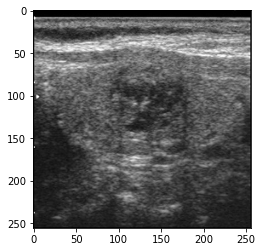

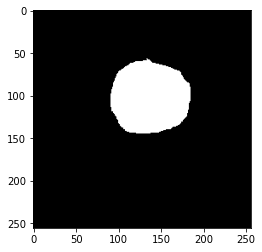

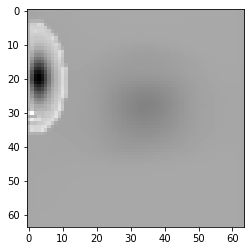

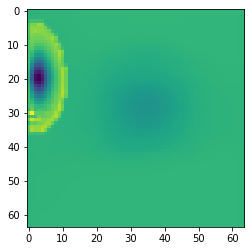

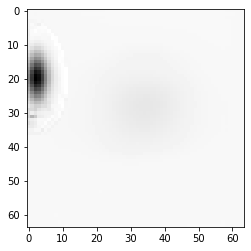

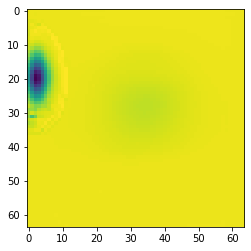

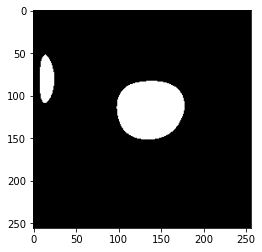

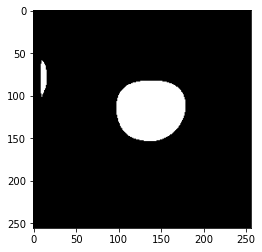

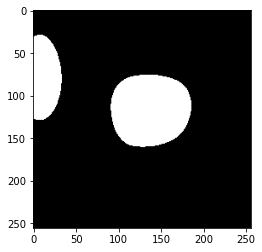

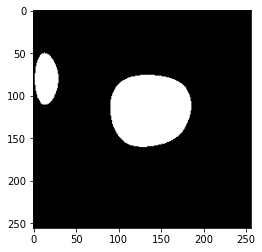

In [ ]:
plt.imshow(image, cmap = 'gray')
plt.show()

plt.imshow(mask, cmap = 'gray')
plt.show()

plt.imshow(ref_map_mean.detach().cpu().numpy(), cmap = 'gray')
plt.show()
plt.imshow(ref_map_mean.detach().cpu().numpy())
plt.show()
plt.imshow(ref_map_mode.values.detach().cpu().numpy(), cmap = 'gray')
plt.show()
plt.imshow(ref_map_mode.values.detach().cpu().numpy())
plt.show()

plt.imshow(max_pred0.detach().cpu().numpy(), cmap = 'gray')
plt.show()

plt.imshow(max_pred1.detach().cpu().numpy(), cmap = 'gray')
plt.show()

plt.imshow(max_pred2.detach().cpu().numpy(), cmap = 'gray')
plt.show()

plt.imshow(max_pred3.detach().cpu().numpy(), cmap = 'gray')
plt.show()